# ROSSMANN STORE SALES 

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. we've found at a kaggle competition, where you can download the dataset here: **https://www.kaggle.com/c/rossmann-store-sales/data**.

First of all, we need to understand what is our business problem. Therefore, we created a context to help us build the solution. So, we'll follow these four steps.

- What is the context?
    - At a meeting with the leads of each department, the Rossmann's CEO made a proposal to renovate all of their store.

- What is the couse? 
    - The Rossmann's CEO want to predict how much each store will sell on next 6 weeks. He need to know if the budget will be enough to make a renovate each store.
    
- Who will lead the project?
    - We need someone who really know what is the business problem,  because he will lead the solution. Therefore, he's our stakeholder.

- How will be our solution?
    - What is the format?
        - granularity(hour,day,product) ---> 6 weeks
        - Problem type(Classification, regression, clustering etc) ---> Regression
        - How we will deliver? (dashboard, csv, telegram bot) ---> Telegram bot
        

In the next step, we'll build our solution. Therefore, we'll follow all of these steps bellow.

- **0.0.** Data Collection.
- **1.0.** Data description.
- **2.0.** Feature Engineering
- **3.0.** Filtering the features
- **4.0.** Exploratory Data Analysis
- **5.0.** Data preparation
- **6.0.** Feature selection
- **7.0.** Machine Learning Modelling
- **8.0.** Hyperparameter fine tuning
- **9.0.** Translation and interpretation of the error
- **10.0.** Deploy model to production

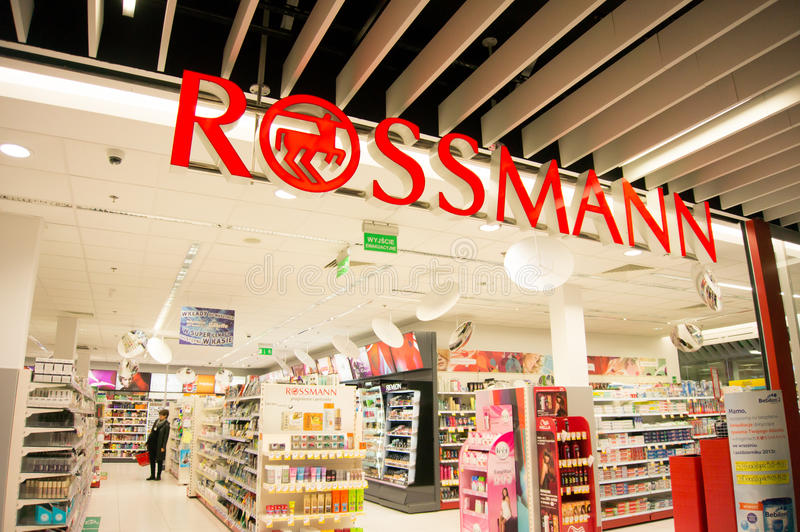

In [77]:
Image("img/rossmann_store.png")

# 0.0. IMPORTS

In [11]:
import pandas              as pd
import inflection
import math
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import datetime
import xgboost             as xgb
import pickle
import json
import requests

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso


from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML
from tabulate              import tabulate
from scipy                 import stats

## 0.1. Helper Functions

In this step, i'll documentation all of the functions that we will need to use in the next sections.

In [12]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

    
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))


def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

In [13]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

We are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

- **File**
    - train.csv - historical data including Sales
    - test.csv - historical data excluding Sales
    - sample_submission.csv - a sample submission file in the correct format
    - store.csv - supplemental information about the stores
    


- **Data fields** --> Most of the fields are self-explanatory. The following are descriptions for those that aren't.

    - Id - an Id that represents a (Store, Date) duple within the test set
    - Store - a unique Id for each store
    - Sales - the turnover for any given day (this is what you are predicting)
    - Customers - the number of customers on a given day
    - Open - an indicator for whether the store was open: 0 = closed, 1 = open
    - StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    - SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
    - StoreType - differentiates between 4 different store models: a, b, c, d
    - Assortment - describes an assortment level: a = basic, b = extra, c = extended
    - CompetitionDistance - distance in meters to the nearest competitor store
    - CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
    - Promo - indicates whether a store is running a promo on that day
    - Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    - Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
    - PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

However, we'll load each dataset and merge the **"train.csv"** with **"store.csv"**, to build a dataframe that we'll call **"df_raw"**. It's important to know that **"test.csv"** will be use just in the final sections. 

In [14]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory = False)
df_store_raw = pd.read_csv("data/store.csv", low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
211247,513,5,2015-01-23,13863,1707,1,0,0,0,a,a,400.0,8.0,2013.0,0,NaN,NaN,NaN


# 1.0. DATA DESCRIPTION

This step is extremely important. Here, we will understand how challenging the problem is. It's important to know somethings that will help during the projetct. Therefore, this section will include the following tasks:

- Rename Columns
- Data Dimensions
- Data Types
- Check missing values
- Fillout missing values
- Change Types
- Descriptive Statistical

In [15]:
df1 = df_raw.copy()

In [16]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

Here, let's rename the columns to be more easier to our queries. We'll use a snake case pattern that refers to the style of writing in which each space is replaced by an underscore (_) character, and the first letter of each word written in lowercase. It is the most common naming convention used in computing as identifiers for variable, function, and file names. For example: "DayOfWeek" --> "day_of_week" 

In [17]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x:inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename

df1.columns = cols_new

In [18]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

Let's understand how big our dataset is. This will be important because a robust machine learning model needs a considerable amount of data to train our algorithm. As you can see below, we have **1017209** rows and **18** columns.

In [19]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

This step is important for us to understand what is the type of our features. Therefore, we need to treat each variable according to its specific type ... for example, we cannot treat a date as a number or as a text, we cannot treat a number as a text. It is necessary for us to understand the context of our business for the changes to be made.

As we can see below, our columns "date" is like a "object"...we will change it to "datetime" type.

In [20]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [21]:
#changing date's type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

This step is extremely important because our machine learning algorithms are not able of handling null values. To solve this problem there is no right answer, it will depend on your business context, we have to be aware of it and test what will be best suited to that situation. There are three ways to fix this.

- Exclude lines with null values.
- Replace with the average or median, for example.
- Change according to the business context.

This choice is very important because, if we choose to exclude the rows from our data set, depending on the amount of null values, we will eliminate a considerable amount of data so that our model could train.

In [22]:
df1.isna().sum().sort_values(ascending = False)

promo_interval                  508031
promo2_since_week               508031
promo2_since_year               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
open                                 0
day_of_week                          0
date                                 0
sales                                0
customers                            0
school_holiday                       0
promo                                0
state_holiday                        0
store_type                           0
assortment                           0
promo2                               0
store                                0
dtype: int64

## 1.5. Fillout NA

As I said above, there is no 100% correct or 100% wrong answer about how you should treat the missing values in your dataset. Every choice has a waiver. You have to be aware of this and test what will best suit that situation.

Therefore, this section will focus on filling in these null values. For that to happen, I chose to use the business context to solve our problem. Below, we will explain each change.

- competition_distance
    - This variable tells us how far the nearest competitor is from our store. I chose to replace it with 200000, as this will be big enough to tell us that there is no competitor close to our store.
    
- competition_open_since_month
    - This column tells us how long in months the competing store opened. We will replace it with the month that was filled in the date column.

- competition_open_since_year
    - This column tells us how long in years the competing store has opened. We will replace it with the year that was filled in the date column.
    
- promo2_since_week
    - describes the calendar week when the store started participating in Promo2. We will extract the week from the date column and replace the values that are null.
    
- promo2_since_year
    - describes the year when the store started participating in Promo2. We will extract the year from the date column and replace the values that are null.
    
- promo_interval 
    - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store. We replaced the null values with 0 and checked if the store participated in promo2 or not represented by 0 and 1. 

In [23]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

As we can see below, there's no more missing values.

In [24]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

After the steps above, we often change something. Therefore, we will make sure that all types are correct.

So, we changed the column types:

- "competition_open_since_month" and "competition_open_since_year" to "int" 
- "promo2_since_week" and "promo2_since_year" to "int".

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistical

This step is essential. It is necessary that we separate the numerical variables from the categorical variables. Because each will have a different form of analysis.

In [27]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

For the numerical variables we use two types of analysis.
- Central tendency
    - average 
    - median

- Dispersion 
  - std - standard deviation
  - min 
  - max 
  - range
  - skew
  - kurtosis

In [28]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Let's look at our "sales" column
   - Min = 0, means that on that day the store was closed.
   - Max = 41551
   - Range = 451151 - 0
   - Mean = It tells us that on average, 5773 sales are made per day.
   - Median = Median very close to the average
   - Std = Tell us that our sales may vary by +/- 3849, that is, there are days that total sales are (5773 + 3849) and there are days that total sales are (5773 - 3849)
   - Skew = Informs us how shifted our graph is in relation to the origin.
   - Kurtosis = Tells us how "pointy" our distribution is, or how close to a normal distribution it is.

### 1.7.2. Categorical Attributes

For categorical variables we will use the boxplot, which provides a visual analysis of the position, dispersion, symmetry, tails and outliers of the data set.

From the boxplot below we can get some conclusions:

- state_holiday --> Holiday b has a median higher than A but very similar to C.
- store_type --> type of store b has a lot more outliers and a larger amount of sales. Store b has a very large amount of data around the median. A and D have a similar dispersion around the median.
- assortment --> b has more sales compared to other types of assortment

In [29]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

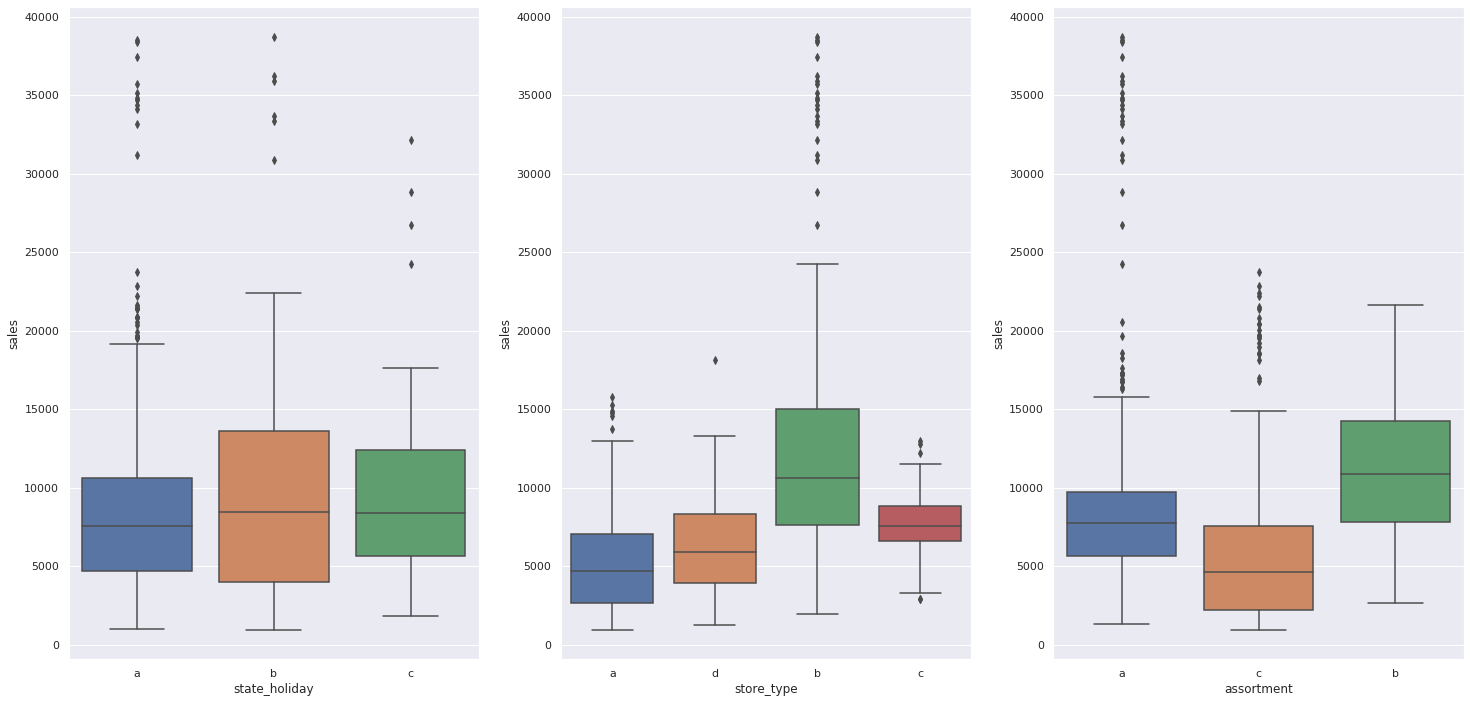

In [30]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# 2.0. FEATURE ENGINEERING

In [32]:
df2 = df1.copy()

To compose this step, we created a mind map hypothesis. It's a easy tool to visualize every opinions about our business context. So, we'll create some features that will be useful in the exploratory data analysis and to get some insights, useful to understand what is the influence of each variable to our prediction variable. This step is useful to have organized data. Therefore, we need to answer some questions:

- What features will be necessary to validate every single hypothesis?
- What's the phenomenon that we are modelling?
     - Sales
- What's the agent descriptions?
     - Age, Sex, Job

The Final List of Hypothesis will answer which hypothesis is true or false.

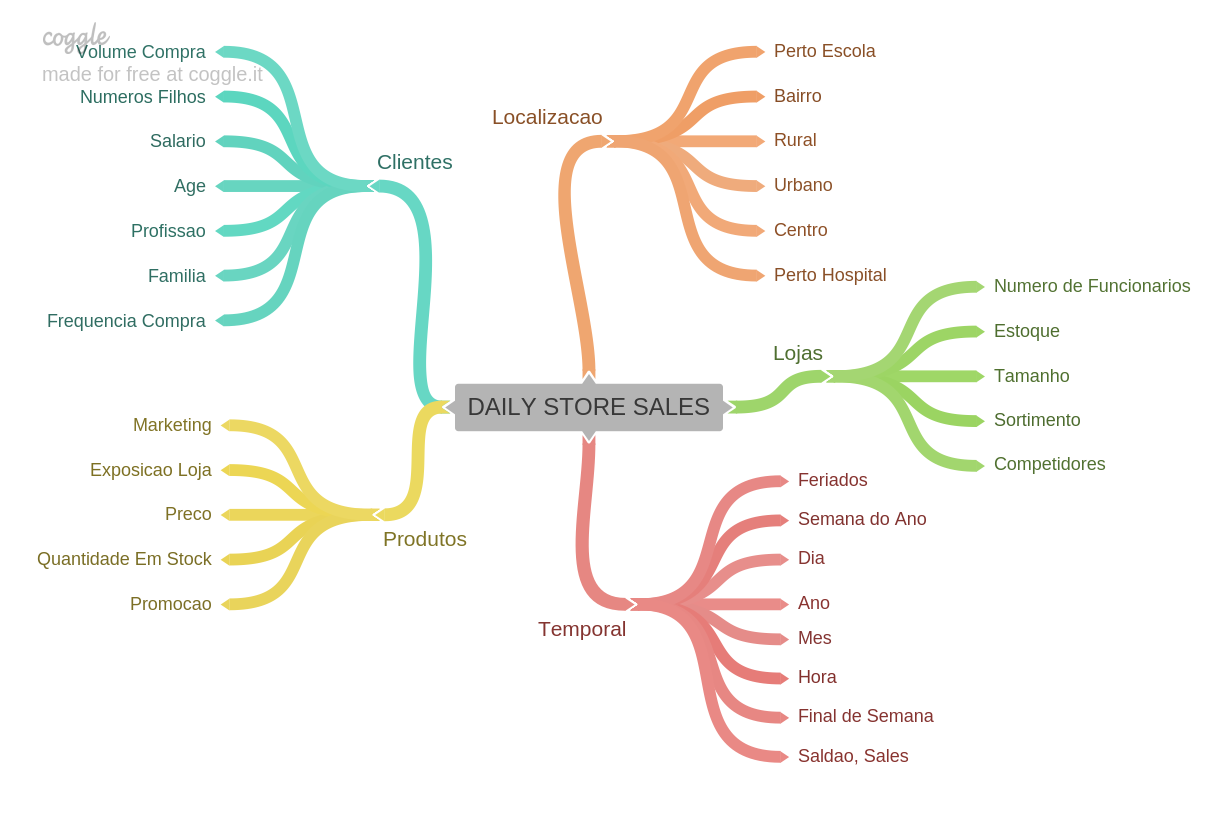

In [33]:
Image("img/MindMapHypothesis.png")

## 2.1. Creation of Hypotheses

### 2.1.1. Store's Hypothesis

**1.** Stores with a larger workforce should sell more.

**2.** Stores with a larger inventory should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less

**6.** Stores with longer competitors should sell more

### 2.1.2. Product's Hypothesis

**1.** Stores that invest more in marketing should sell more.

**2.** Stores that exhibit more product in store windows should sell more.

**3.** Stores that have lower prices should sell more.

**4.** Stores that have more aggressive promotions (bigger discounts), should sell more

**5.** Stores that have prices less for longer products should sell more.

**6.** Stores with more promotion days should sell more

**7.** Stores with more consecutive promotions should sell more.

### 2.1.3. Time's Hypothesis

**1.** Stores opened during the holiday should sell more

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.2. Final List of Hypotheses

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less

**3.** Stores with longer competitors should sell more

**4.** Stores that have prices less for longer products should sell more.

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the holiday should sell more

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.3. Feature Engineering

To validate our hypothesis, we'll create some features that will be useful to us. Therefore, here is the attributes:

- year
- month
- day
- week of day
- year week = Ex: 2019(year)-22(week)

Some variables have been modified to suit our questions. We replaced the rows in the "state_holiday" column with "public_holiday", "easter_holiday" and "christmas". We did the same thing to our assortment column.

In [34]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment 
#a = basic, b = extra, c = extended

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
#a = public_holiday, b = easter holiday c = christmas

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')




# 3.0. DATA FILTERING

In [35]:
#Making a copy of the data set we worked on earlier.
df3 = df2.copy()

In [36]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In this step, we will ensure that we will only work with the information that will be important to us. For example, it does not make sense to check sales in one day for a store that was closed. Therefore, we will separate this step into two:

**1.** Filtering Rows.

**2.** Filtering Features.

## 3.1. Filtering Rows

As previously stated, here we will filter the lines that will actually influence our data set. Therefore, we will remove the data whose column "open" is equal to "0", as it will mean that the store was closed, that is, there were no sales on that day. We will also remove the lines that have in the "sales" column equal to "0".

In [37]:
#filtering the rows
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtering Columns

In a similar way, we will remove the columns. These will be:

**1.** Costumer - To use this column, we would apparently have to create a model to predict customers. Therefore,right now, it will not help us.

**2.** Open - As we've removed all the lines that have the value "0", so we will only have those that have the value "1". Since this column will have no variation it will not influence our model or the analysis.

**3.** Promo_interval / "month_map" - We will remove it because we used it to build columns that will give to us the same information,so, from the column "promo_interval" and the column "month_map" we've built the column " is_promo "in the **Fillout NA**.

In [38]:
df3.drop(columns = ['customers','open','promo_interval','month_map'], axis = 1, inplace = True)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY DATA ANALYSIS

Exploratory Data Analysis (EDA) is the process of visualizing and analyzing data to extract insights from it. In other words, EDA is the process of summarizing important characteristics of data in order to gain better understanding of the dataset. Therefore, this part will be done in the following three steps:

- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis

References: 
   - https://medium.com/code-heroku/introduction-to-exploratory-data-analysis-eda-c0257f888676#:~:text=Exploratory%20Data%20Analysis%20(EDA)%20is,better%20understanding%20of%20the%20dataset.
   
   - https://hotcubator.com.au/research/what-is-univariate-bivariate-and-multivariate-analysis/

In [39]:
df4 = df3.copy()

## 4.1. Univariate Analysis

Univariate analysis is the most basic form of statistical data analysis technique. When the data contains only one variable and doesn’t deal with a causes or effect relationships then a Univariate analysis technique is used.

### 4.1.1. Response Variable

We built a distplot to see how our response variable is distributed. As we can see, it is close to a normal distribution, however, it has a positive skewness, so it is shifted to the left. It is important to understand that machine learning, cost function or a neuron potential values are the quantities that are expected to be the sum of many independent processes (such as input features or activation potential of last layer) often have distributions that are nearly normal.

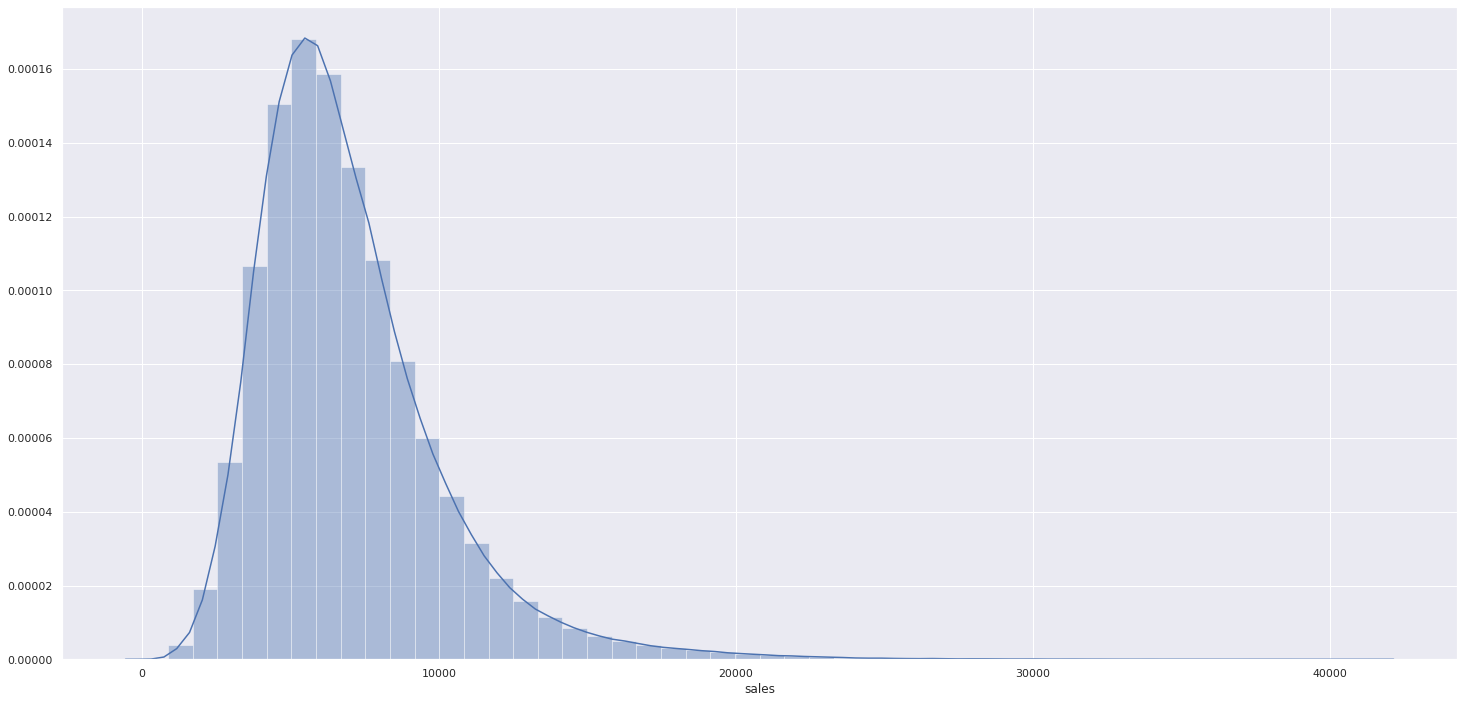

In [39]:
sns.distplot(df3['sales'])

### 4.1.2. Numerical Variable

To visualize the distribution of our numeric variables, we will construct a histogram to see how each feature behaves.

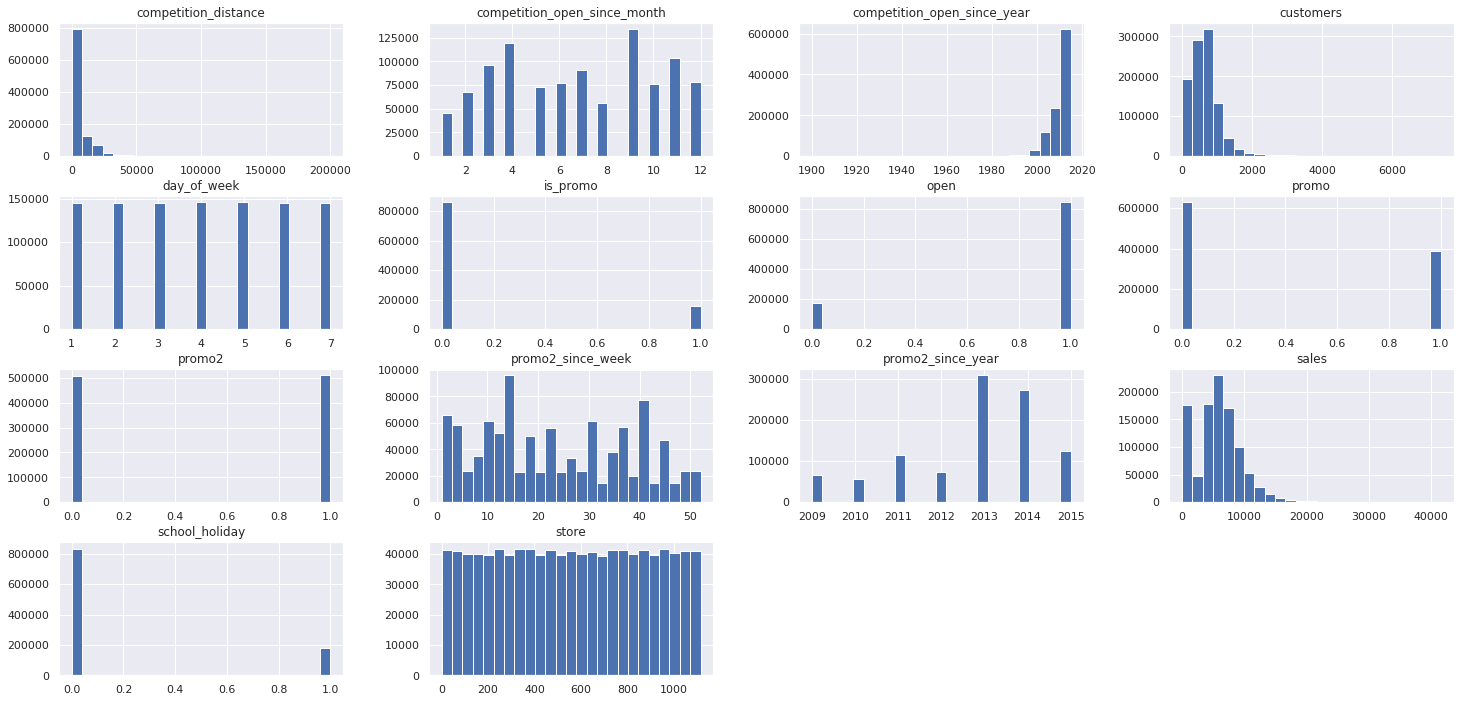

In [40]:
num_attributes.hist(bins = 25);

From the graphs above, we can get some conclusions:

- **competition_distance** -> we can see that we have bigger concentrations in smaller intervals. So, there's a lot close competitors.

- **competition_open_since_month** ->  has an increase until the fourth month and reaches the maximum. From that there is a fall. Therefore, this feature has a certain variation.

- **day_of_week** -> There is no variation, so, the day of the week will not influence sales. There is no variation.

- **is_promo** -> we have a lot more sales when there are no promotions. This can be an insight, we will check soon.

- **promo2_since_year** -> there is a very high peak in 2013, we need to check what happened that year.

### 4.1.3. Categorical Variable

In [41]:
df4.select_dtypes(include = 'object').columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

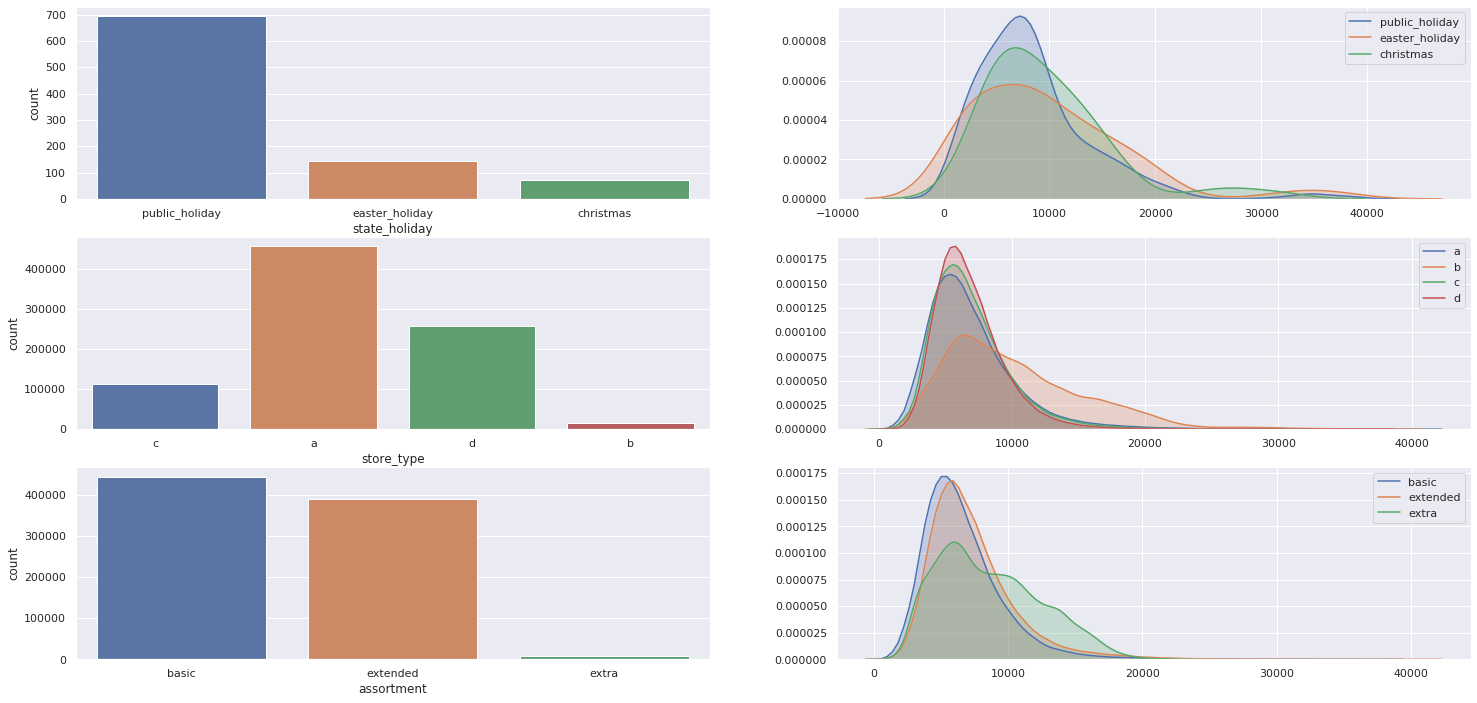

In [42]:
#state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday',shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday',shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label = 'christmas',shade = True)

#store_type
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label = 'a',shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label = 'b',shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label = 'c',shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label = 'd',shade = True)

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label  = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)


From all the plots above, we can get some conclusions:

- **state_holiday** -> We have a much larger amount of sales on public holidays, but at Christmas, which has a smaller amount of sales than easter_holiday, it has a higher peak.

- **store_type** -> The store_type "a" that sells more, does not have such a peak compared to the others.

- **assortment** -> We see that stores with the "extra" type assortment sell less, but have a higher distribution. So, there are stores that sell more with the "extra" assortment and stores that sell less.

## 4.2. Bivariate Analysis

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less

**3.** Stores with longer competitors should sell more

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the holiday should sell more

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

### H1. Stores with a larger assortment should sell more.

**False** Stores with a larger assortment sell less.

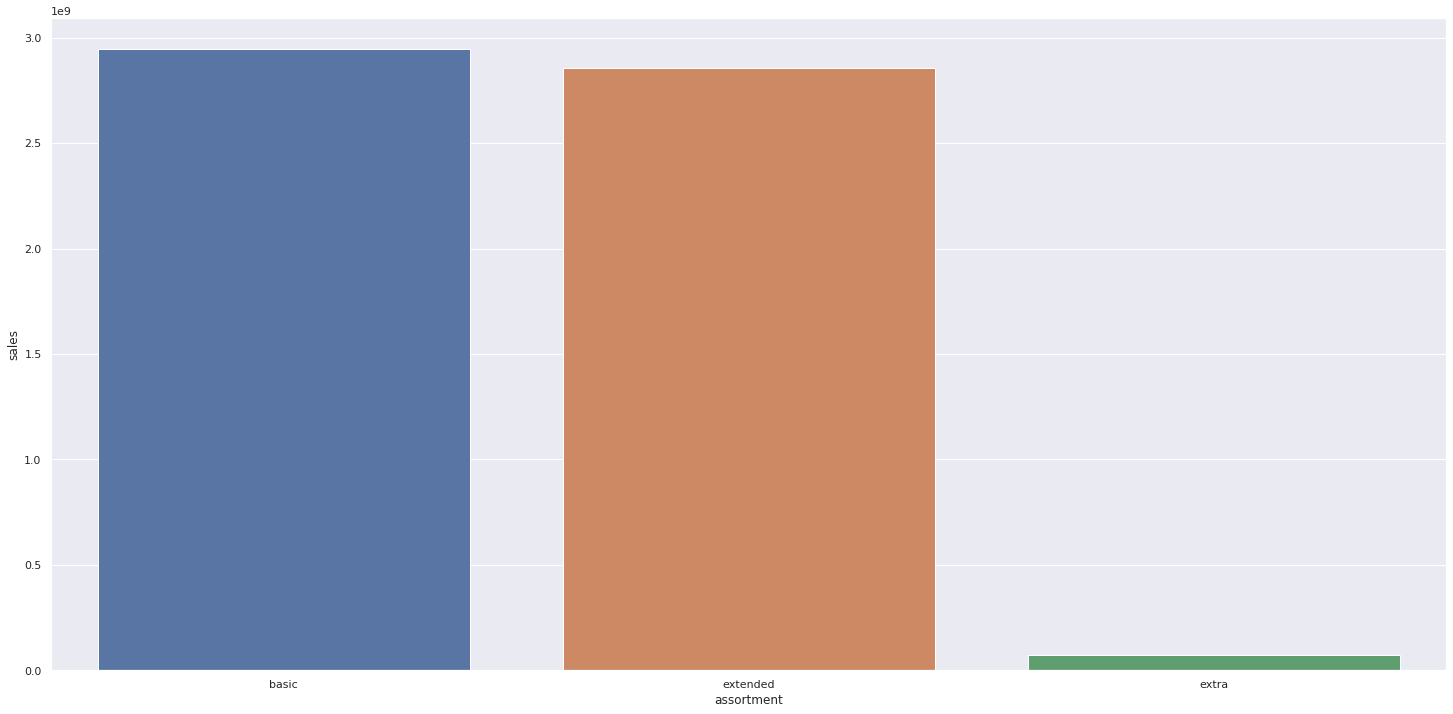

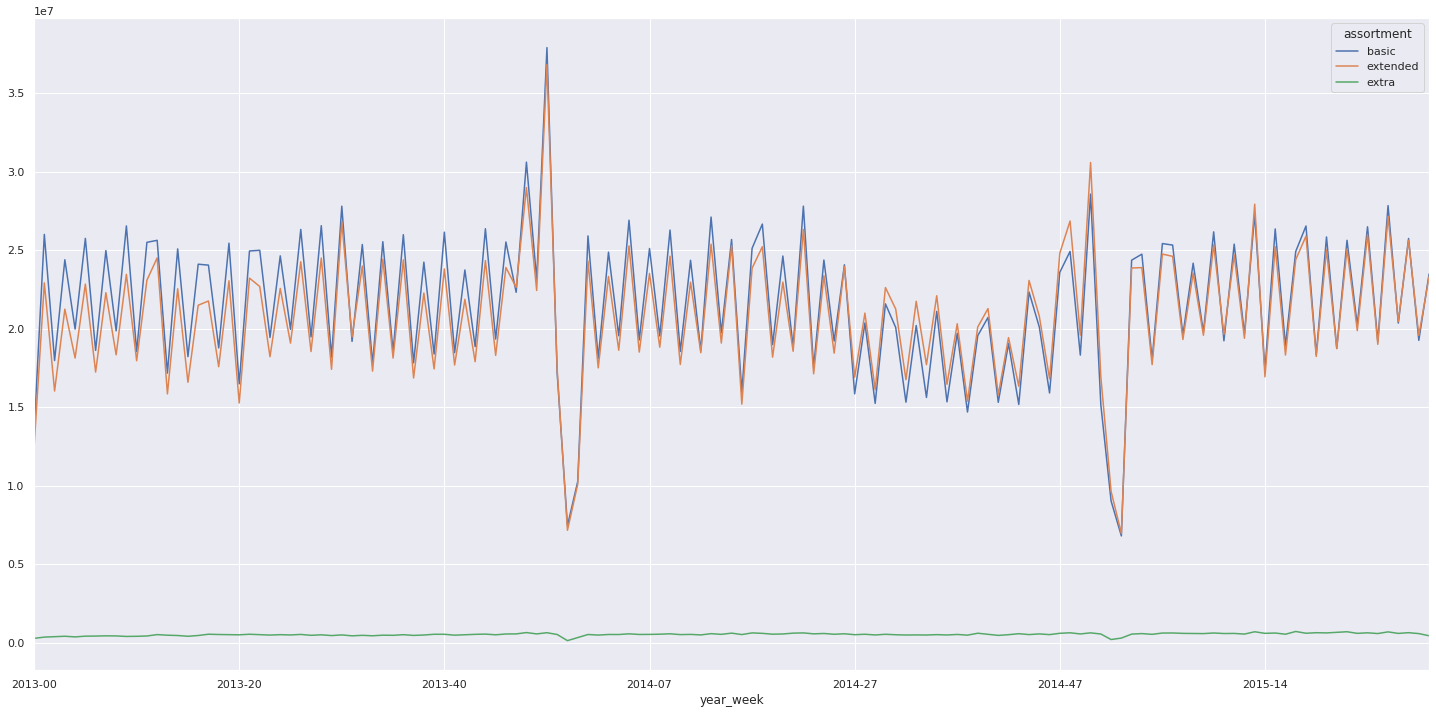

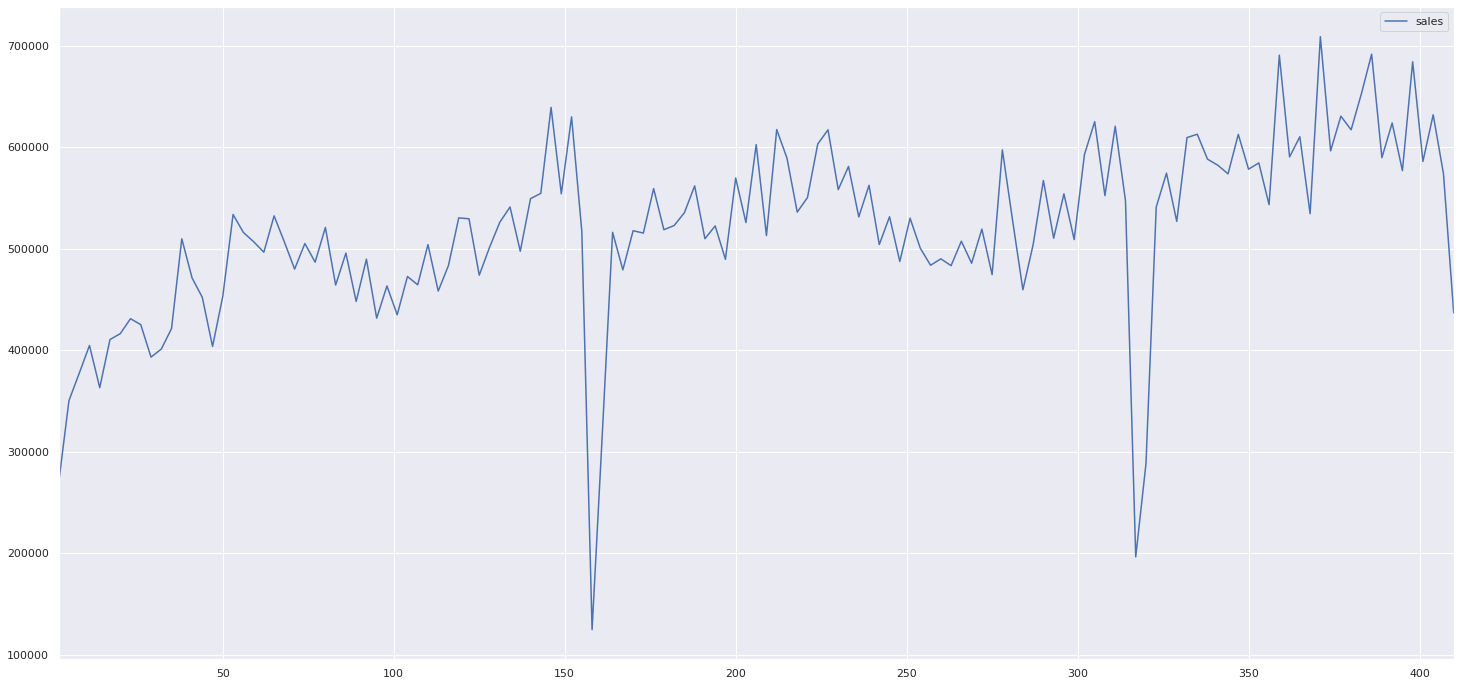

In [43]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
aux3.plot()


aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index = 'year_week',columns = 'assortment', values = 'sales')
aux4.plot()

### **H2** Stores with closer competitors sell less

**False** Stores with closer competitors sell more.

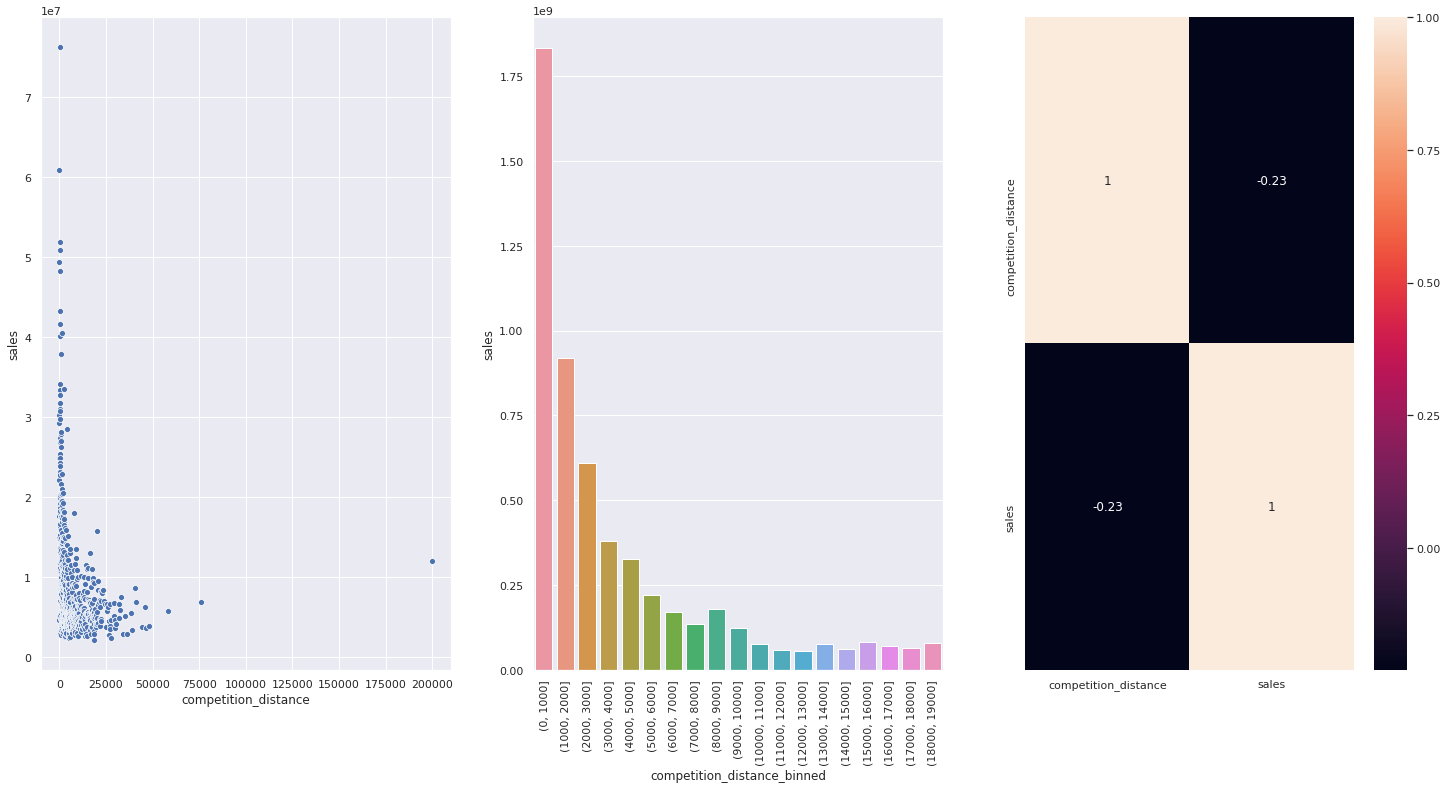

In [44]:
plt.subplot(1,3,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90)
    
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3. Stores with longer competitors should sell more.

**False** Stores with longer competitors sell less.

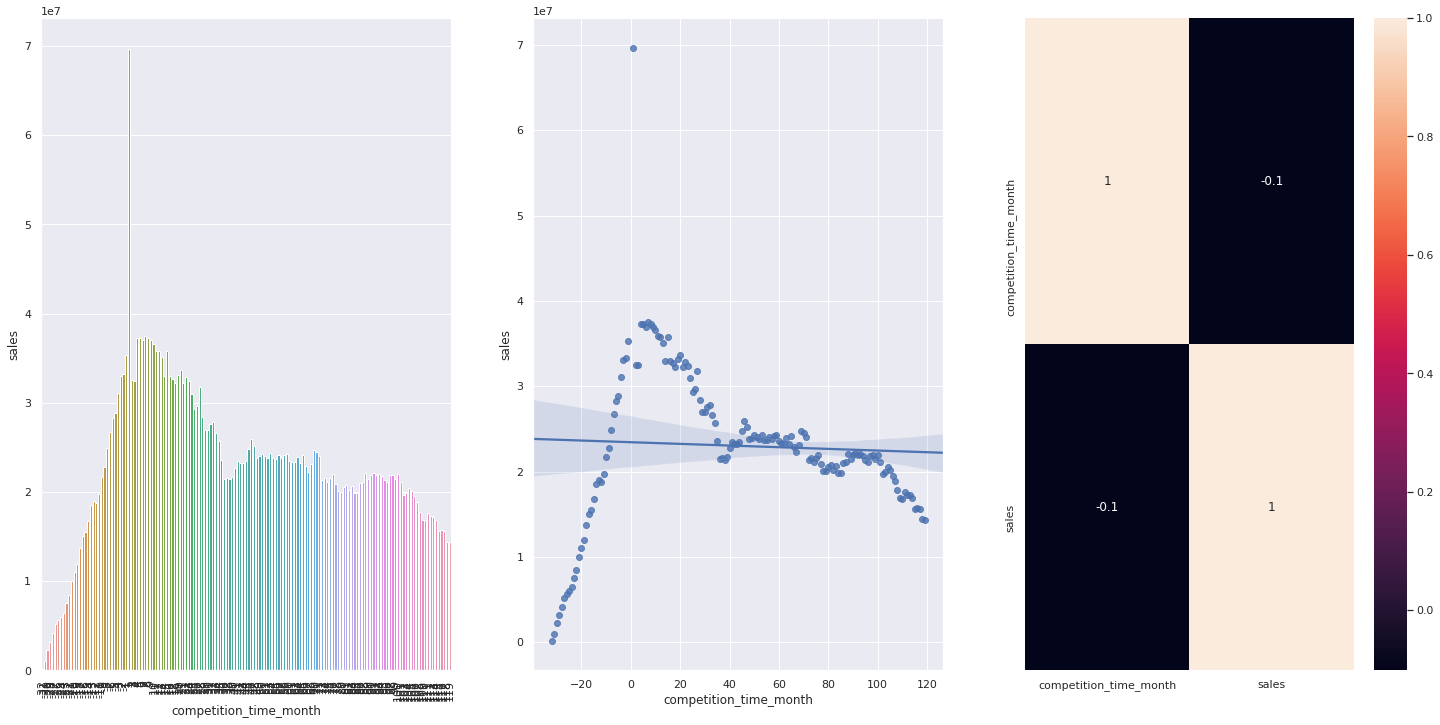

In [45]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H4. Stores with active promotions for longer should sell more.

**False** Stores with active promotions sell less after a certain duration.

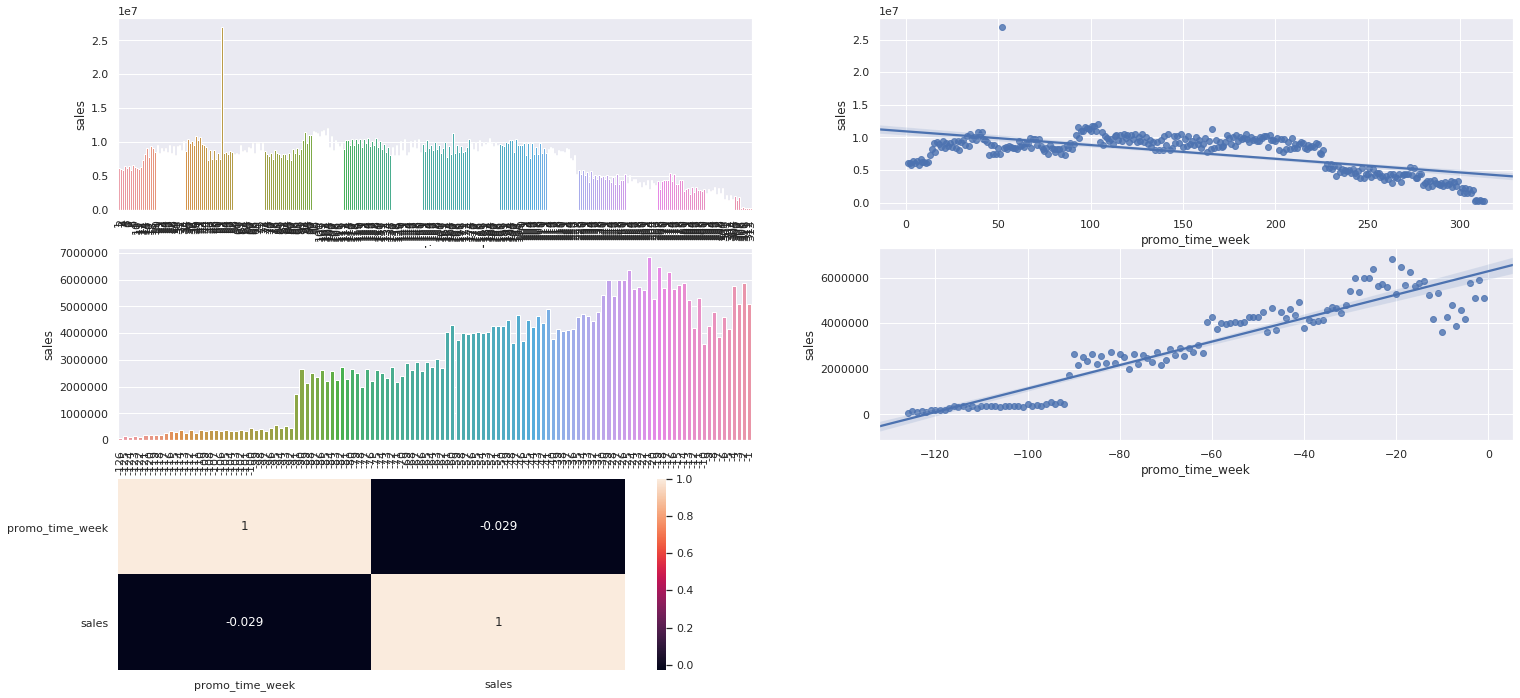

In [46]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(3,2,1)
aux2 = aux1[aux1['promo_time_week'] > 0] #periodo extendido
sns.barplot(x = 'promo_time_week',y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(3,2,2)
sns.regplot(x = 'promo_time_week',y = 'sales', data = aux2);

plt.subplot(3,2,3)
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x = 'promo_time_week',y = 'sales', data = aux3);
plt.xticks(rotation = 90);### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

plt.subplot(3,2,4)
sns.regplot(x = 'promo_time_week',y = 'sales', data = aux3);

plt.subplot(3,2,5)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True );

### <s>H5. Stores with more promotions should sell more.<s>

### H6. Stores with more consecutive promotions should sell more.

**False** Stores with more consecutive promotions sell less.

In [47]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


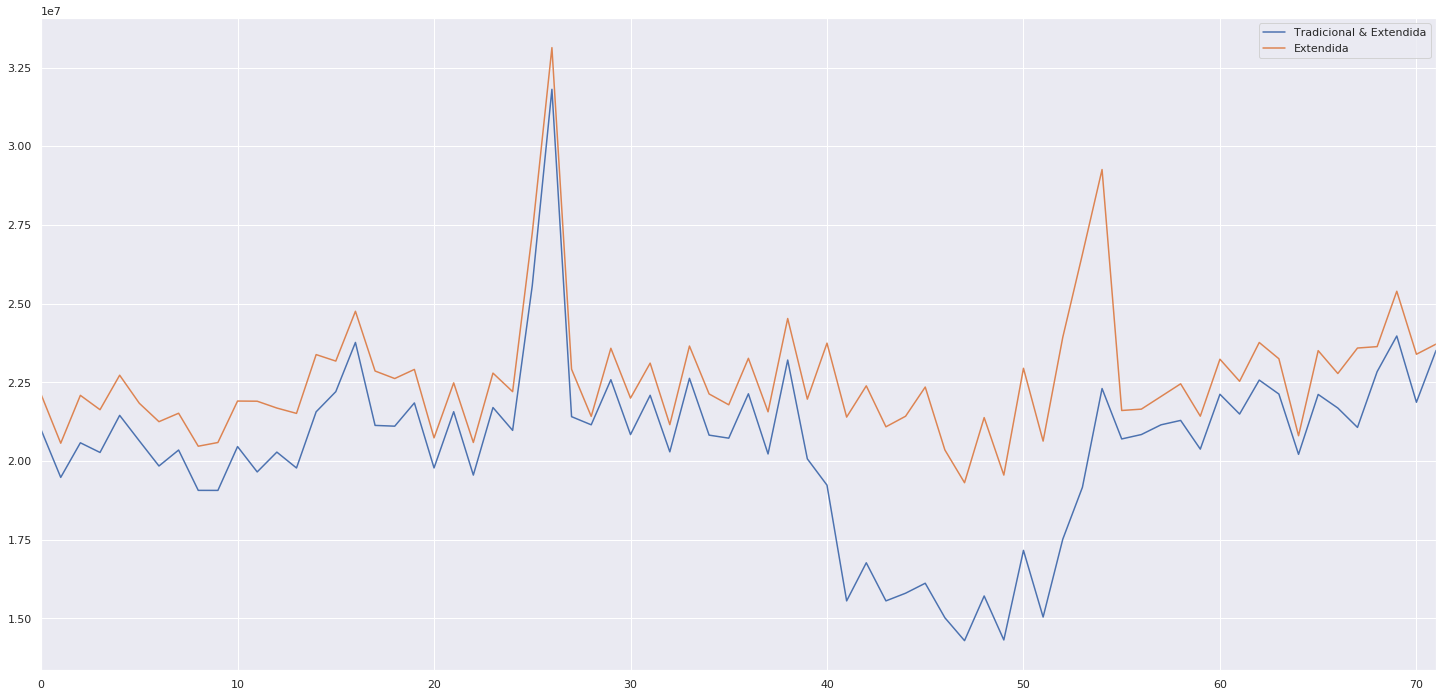

In [48]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)
ax.legend(labels = ['Tradicional & Extendida', 'Extendida'])

### H7. Stores that were opened during the Christmas holiday should sell more.

**False** Stores open during the Christmas holiday sell less.

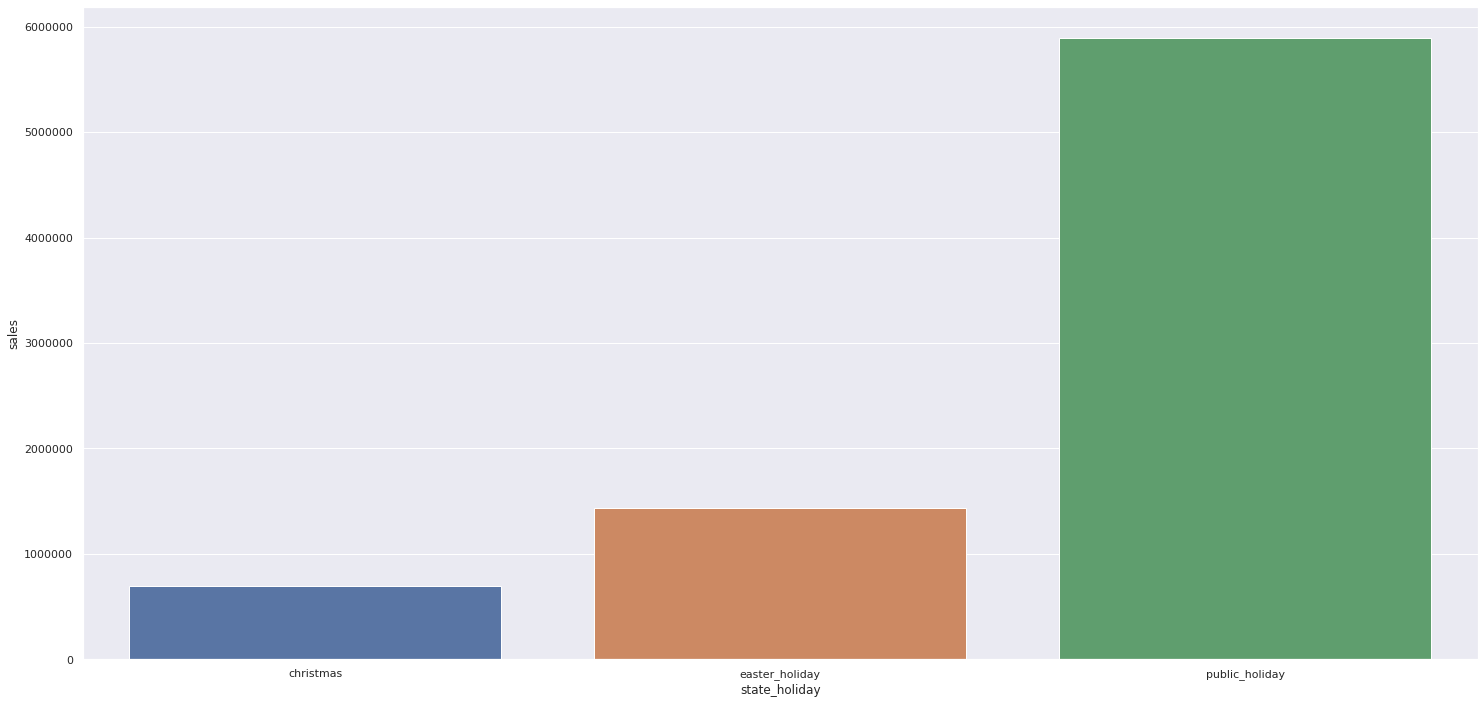

In [49]:
aux1 = df4[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

aux2 = aux1[aux1['state_holiday'] != 'regular_day']
sns.barplot(x = 'state_holiday', y = 'sales', data = aux2)

### H8. Stores should sell more over the years.

**False** Stores sell less over the years.

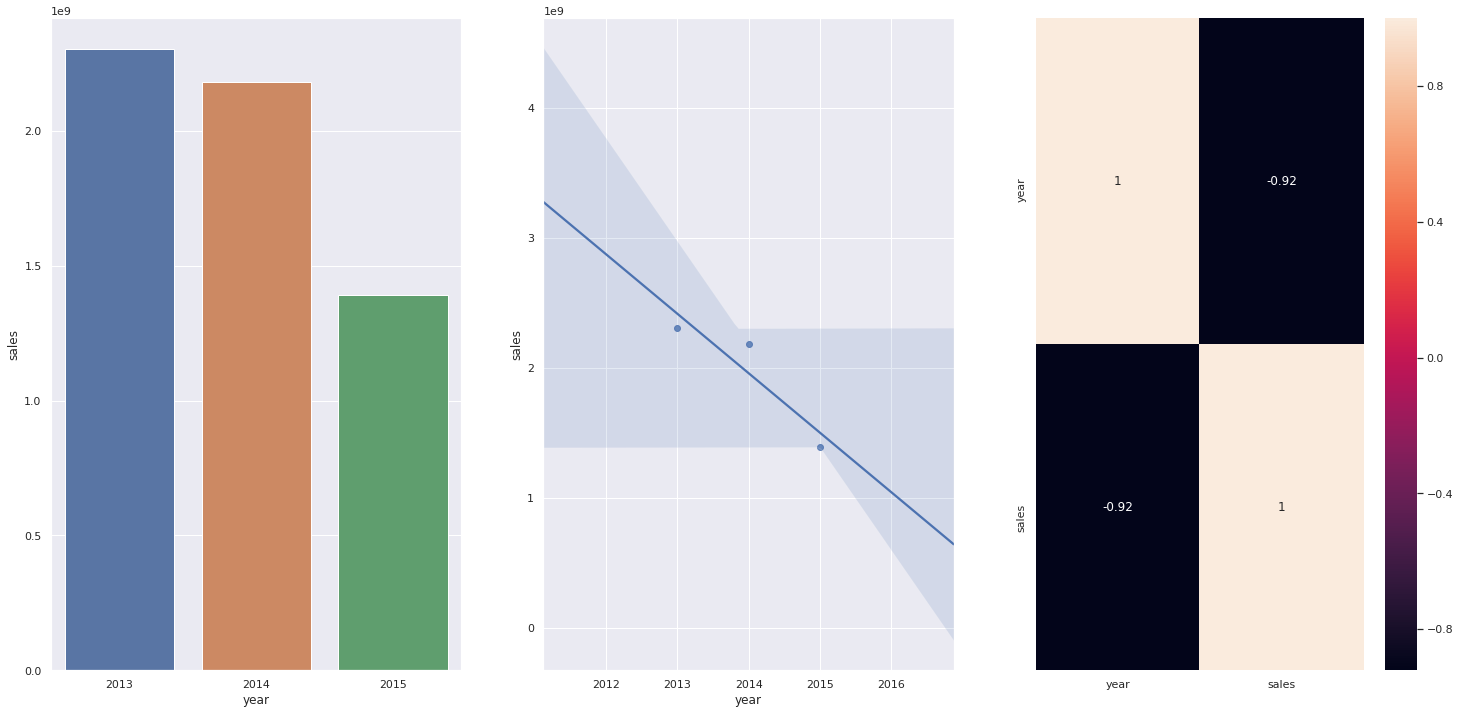

In [50]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year',y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'year',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H9. Stores should sell more in the second half of the year.

**False** Stores sell less in the second half of the year.

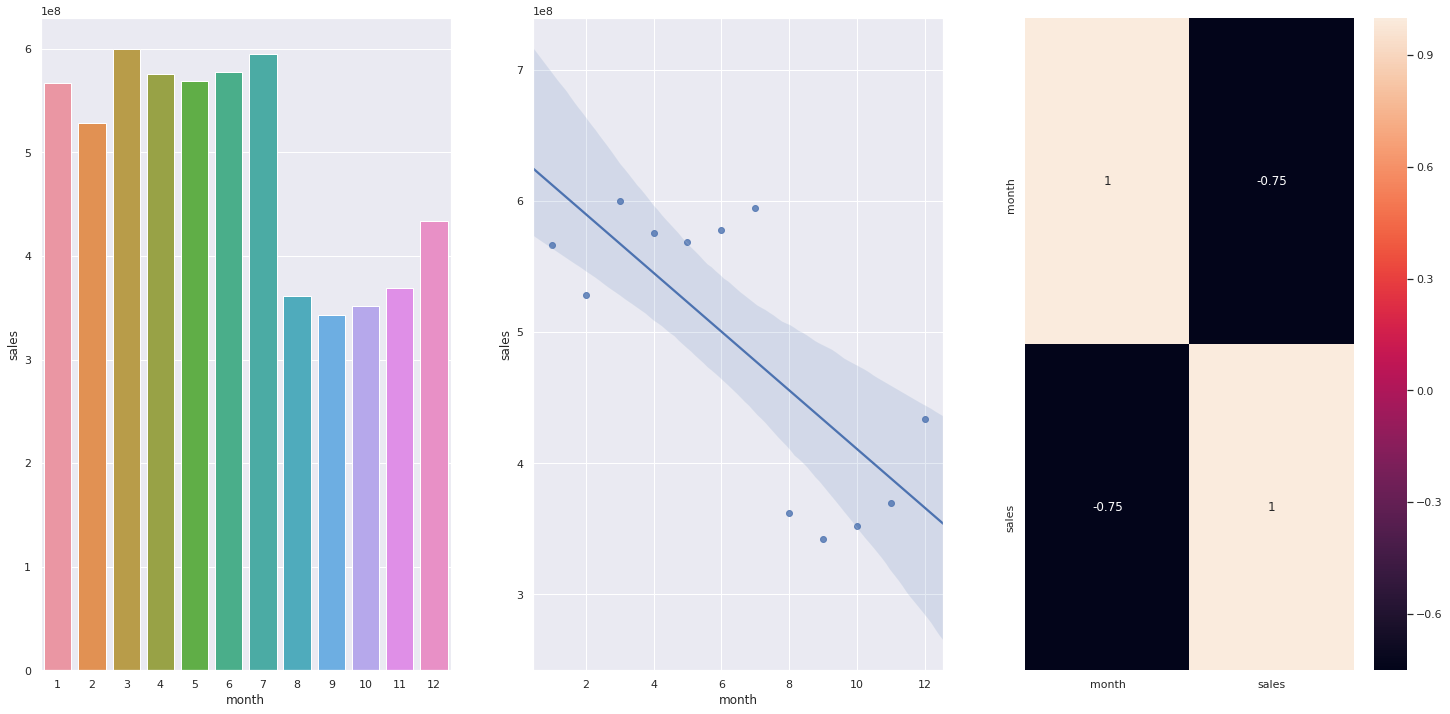

In [51]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month',y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H10. Stores should sell more after the 10th of each month.

**True** Stores sell more after the 10th of each month.

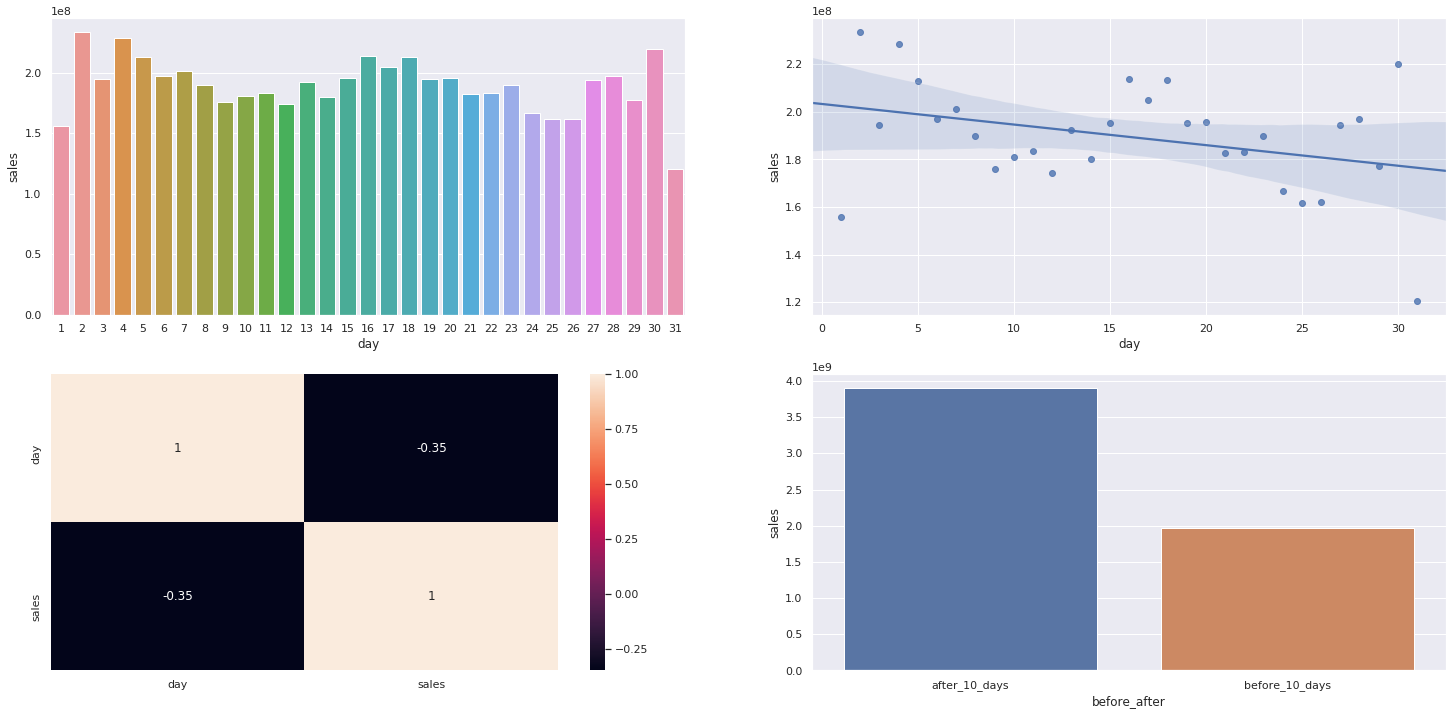

In [52]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day',y = 'sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day',y = 'sales', data = aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2)

### H11. Stores should sell less on weekends.

**True** Stores sell less on weekends.

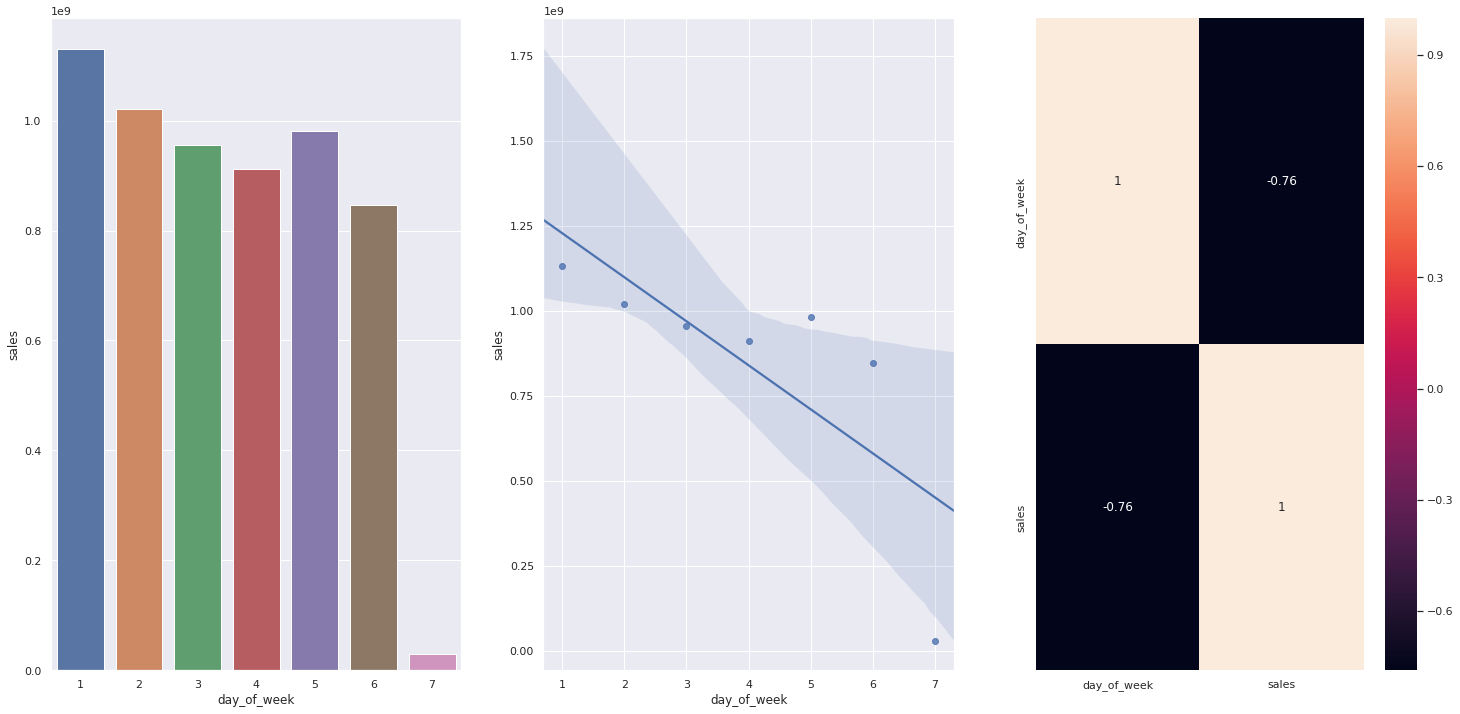

In [53]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week',y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H12. Stores should sell less during school holidays

**True** Stores sell less during school holidays except in July and August.

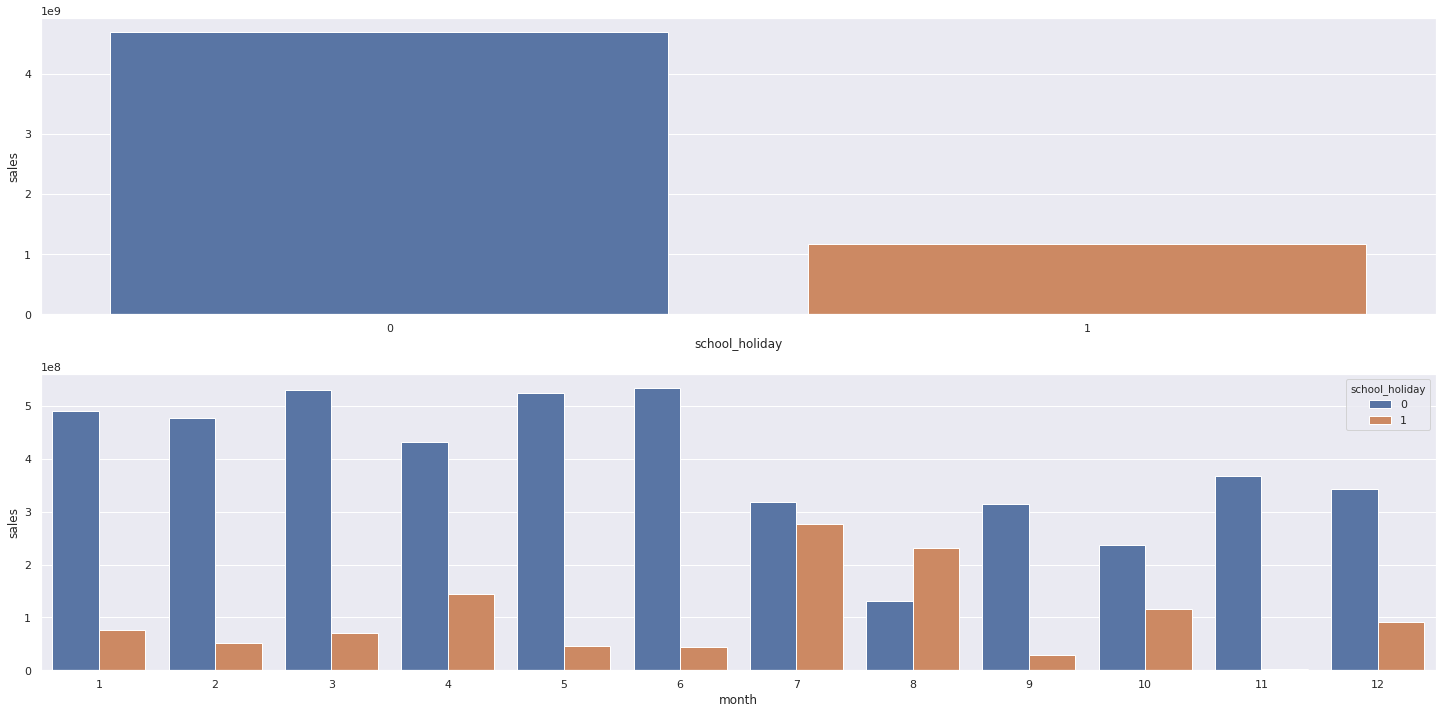

In [54]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday',y = 'sales', data = aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month',y = 'sales',hue = 'school_holiday', data = aux2)


### 4.2.1. Summary of Hypotheses

In [4]:
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']]

print(tabulate(tab, headers = 'firstrow'))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3. Multivariate Analysis

Multivariate analysis (MVA) is based on the principles of multivariate statistics, which involves observation and analysis of more than one statistical outcome variable at a time. Typically, MVA is used to address the situations where multiple measurements are made on each experimental unit and the relations among these measurements and their structures are important.

This step will be done because the machine learning algorithms assume some premises, among them, the Occam’s razor principle. Ockham's rule is associated with the requirement to recognize, for each object analyzed, only one sufficient explanation.

We use the concepts of linear dependency, that is, let's assume that we have two columns that are linearly dependent, that is, whose influence on the problem is similar, we can take one that the effect will be maintained. To find this, we can look at the correlation between variables as an alternative so that we can reduce the dimensionality of our dataset.

This stage will be divided into two:

- Numeric attributes
- Categorical attributes

Let's use this strategy because the multivariate analysis of our variables will be different. That is, to check the correlation between numerical variables, we will use the **Pearson** method and for categorical variables, **Cramér's V** method.

### 4.3.1. Numerical Attributes

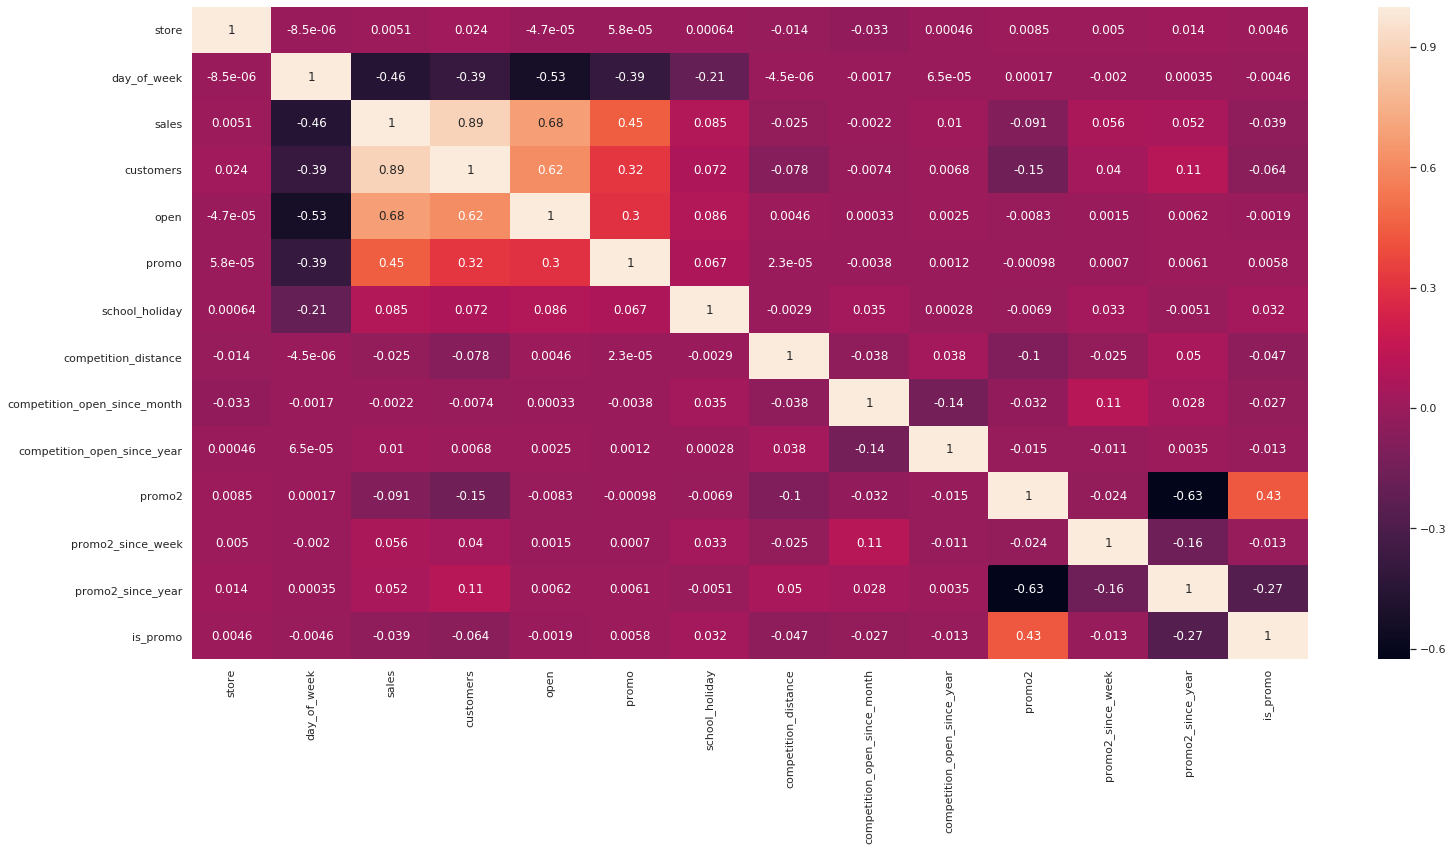

In [56]:
#separating numerical variables and building the heat map
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

We will look at the columns that have the lightest and darkest data, note the following columns:

The variables that have some dependence on the response variable are: 'day_of_week', 'open' and 'promo'. We also have the variable 'Customers', but it would be necessary to build a project to predict this variable and after that, we could use it, so we can remove it.

### 4.3.2. Categorical Attributes

In statistics, Cramér's V (sometimes referred to as Cramér's phi and denoted as φc) is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). Take a look at the formulas below.

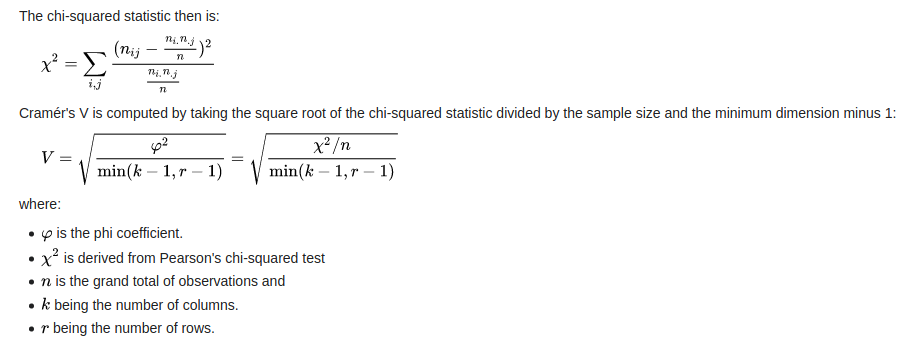

In [5]:
Image("img/cramer'sv1.png")

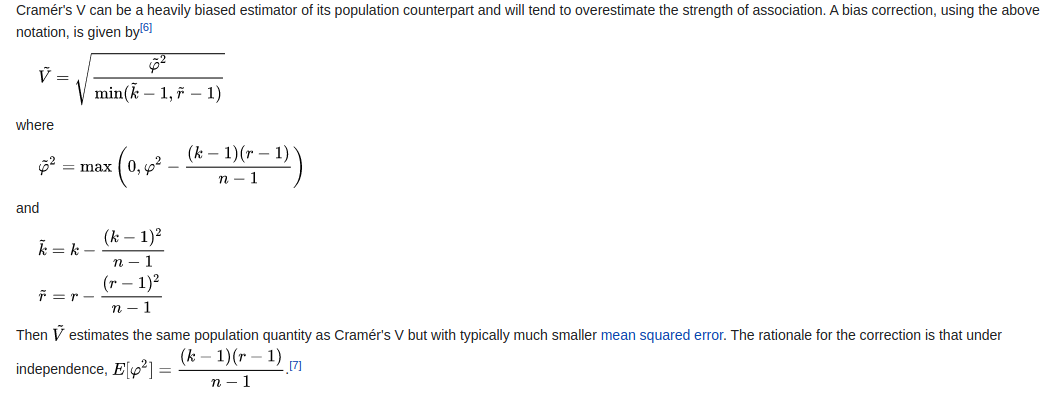

In [6]:
Image("img/cramer'sv2.png")

In [57]:
#only categorical data
a = df4.select_dtypes(include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


Unlike Pearson's coefficient that goes from -1 to 1, Cramér's V goes from 0 to 1. In other words, there is no negative correlation in categorical variables. We can create a function to apply to all other columns.

It is necessary to remember that we will need to modify our function a little, because Cramer's V has a very high bias and it may overestimate our analysis, being necessary to carry out the correction. Observe the formula below.

**The construction of this function was developed in the "Helper Functions" section**

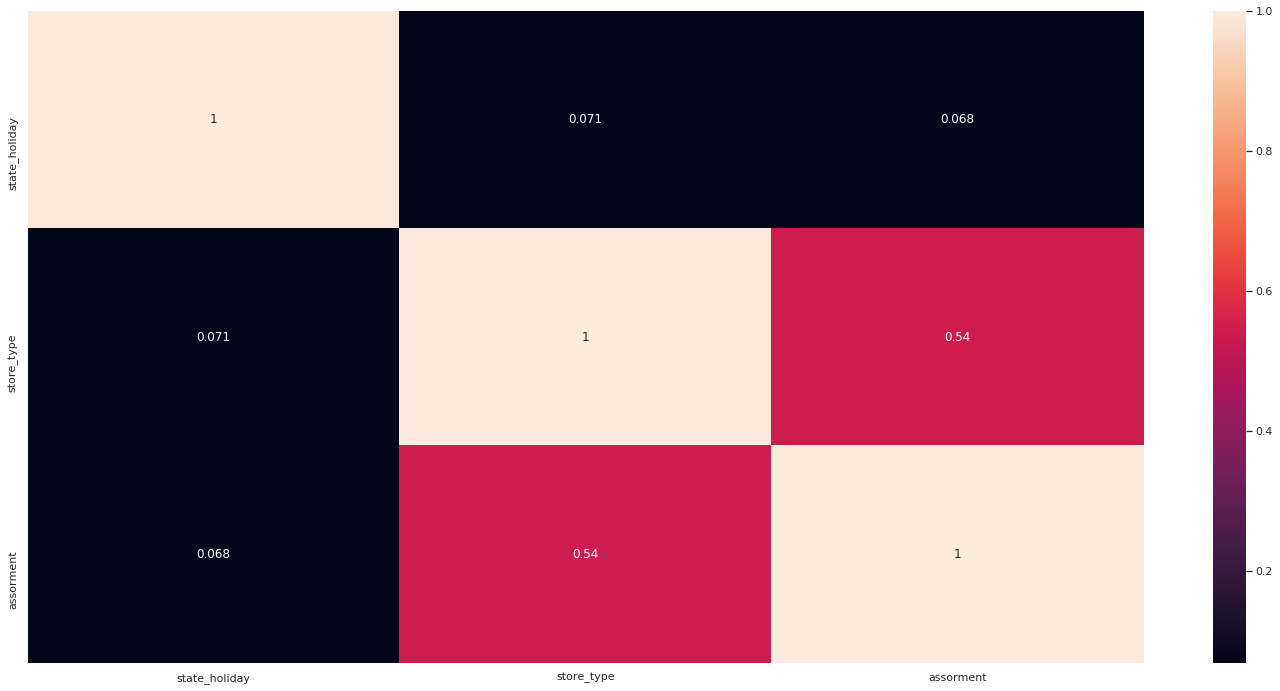

In [58]:
#calculate cramer v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assorment': [a7,a8,a9]
             })

#final dataset
d = d.set_index(d.columns)
sns.heatmap(d , annot = True)

According to the heat map, we found that there is a high correlation between the variables assortment and store type. The result of 0.54 is an average correlation. This means that the bigger the store, the bigger the product range. The other variables have weak correlations with each other.

# 5.0. DATA PREPARATION

In [40]:
df5 = df4.copy()

## 5.1. Normalização

If the population mean and population standard deviation are known, a raw score x is converted into a standard score by

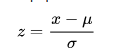

In [41]:
Image("img/norm1.png")

- μ is the mean of the population.
- σ is the standard deviation of the population.

Since there is no normal distribution in our numerical variables, we will not use normalization.

## 5.2. Rescaling

We will check which variables have a high number of outliers. If found, we will use the RobustScaler that performs best for these variables, as it will use quartiles instead of maximum and minimum.

For variables that do not have outliers, we will use MinMaxScaler.

**MinMaxScaler**

Also known as min-max scaling or min-max normalization, is the simplest method and consists in rescaling the range of features to scale the range in [0, 1] or [−1, 1]. Selecting the target range depends on the nature of the data. The general formula for a min-max of [0, 1] is given as:

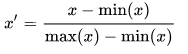

In [42]:
Image("img/norm2.png")

The Min-Max-Scaler application does not change the nature of the variables, maintaining the distributions. What will change is just the range. However, the Min-Max-Scaler application presents a problem that is related to the outliers of the variables, because considering these values in the equation, it can bring the results of the transformed data very close to zero, removing the distribution format.

**RobustScaler**


This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

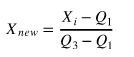

In [43]:
Image('img/norm3.png')

In [44]:
#selecting numerical features
a = df5.select_dtypes(include = ['int64','float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


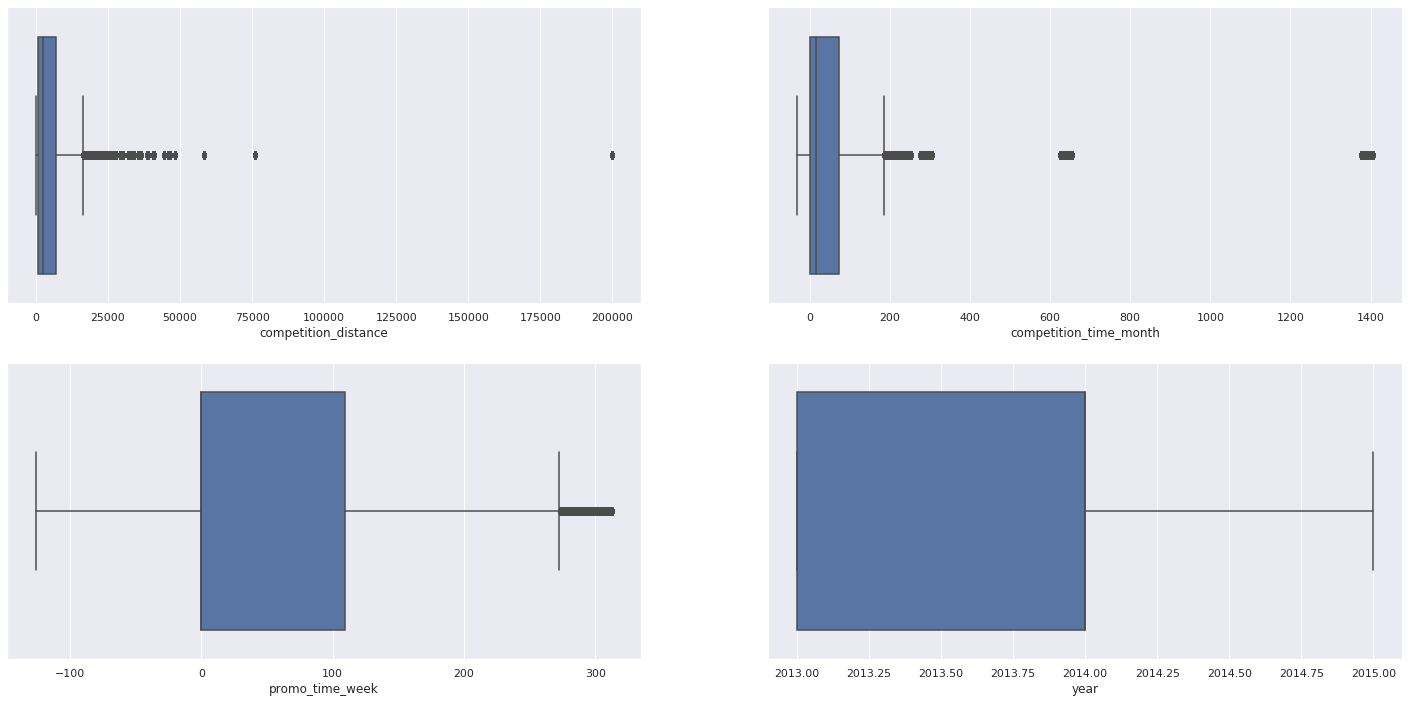

In [45]:
#boxplots
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance'])

plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month'])

plt.subplot(2,2,3)
sns.boxplot(df5['promo_time_week'])

plt.subplot(2,2,4)
sns.boxplot(df5['year'])


- competition_distance -> There are many outliers, so we will use RobustScaler.
- year -> There are no outliers, so we will use MinMaxScaler.
- competition_time_month -> There are many outliers, so we will use RobustScaler.
- promo_time_week -> There aren't many outliers, so we will use MinMaxScaler.

In [46]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance - RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open("parameter/competition_distance_scaler.pkl",'wb'))

#year - MinMaxScaler
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open("parameter/year_scaler.pkl", 'wb'))

#competition_time_month - RobustScaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open("parameter/competition_time_month_scaler.pkl",'wb'))

#promo_time_week - MinMaxScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open("parameter/promo_time_week_scaler.pkl",'wb'))


## 5.3. Transformation

In this stage of data transformation, we will verify three techniques: 

- Encoding
- Transformation of the variable response
- Transformation of nature.

### 5.3.1. Encoding

**Label Enconder**

LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1. This is sometimes useful for writing efficient Cython routines.It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.

**One Hot Encoder**

This type of encoding can be obtained with the OneHotEncoder, which transforms each categorical feature with n_categories possible values into n_categories binary features, with one of them 1, and all others 0. By default, the values each feature can take is inferred automatically from the dataset and can be found in the categories_ attribute.

**Ordinal Encoder**

To convert categorical features to such integer codes, we can use the OrdinalEncoder. This estimator transforms each categorical feature to one new feature of integers (0 to n_categories - 1) as being ordered.

In [47]:
#state_holiday - OneHotEncoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

#store_type - LabelEncoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open("parameter/store_type_scaler.pkl",'wb'))

#assortment - OrdinalEncoder
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In transforming the response variable, we have to approximate the distribution of the response variable to a normal distribution. This is necessary because machine learning algorithms are built on the basis of assumptions, one of which is that the data is normally distributed.For that to happen, we will use the logarithmic transformation.

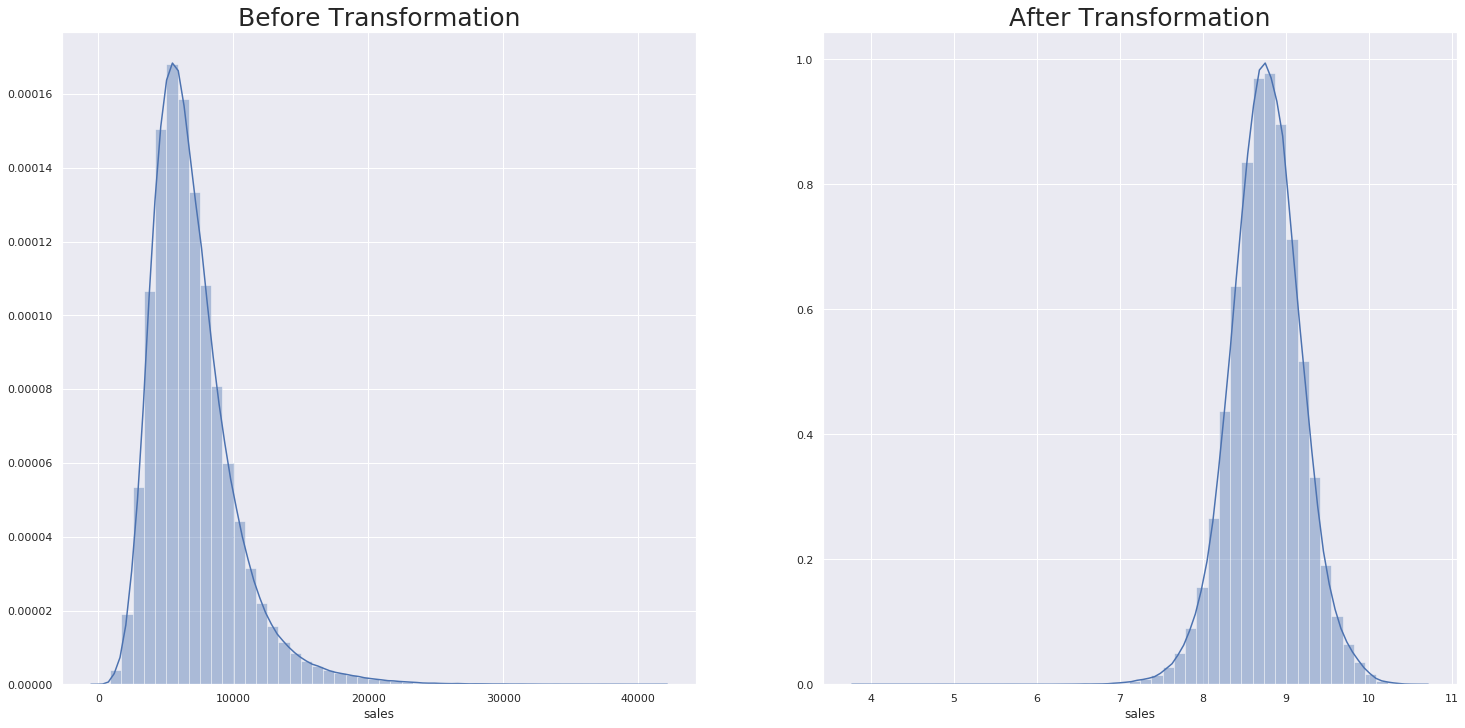

In [48]:
plt.subplot(1,2,1)
sns.distplot(df5['sales'])
plt.title('Before Transformation', fontsize = 25)

plt.subplot(1,2,2)
sns.distplot(np.log1p(df5['sales']))
plt.title("After Transformation", fontsize = 25)

#logarithmic transformation
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In nature transformation, we have to bring the true nature of the data to the dataset. In this case, the variable 'month' is cyclical and has to be transformed, as the months are repeated each year that begins. But for that, we don't just list the months 1 to 12 because we lost the sense of cycle due to the different distances.

For example, we take the month of January 2018, we find that there is a long distance until December 2018, but not necessarily, December 2018 is far from the month of January 2019. What happens is that December 2018 has the same distance as January 2019 than March 2018 has April 2018. And the same distance keeps a cycle.

Therefore, I will use the trigonometric circle by placing the months as arcs and separating them at equal distances. This process will be done for the variables 'day_of_week', 'month', 'day', 'week_of_year'.

In [38]:
#month 
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2* np.pi/12) ))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2* np.pi/12) ))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2* np.pi/30) ))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2* np.pi/30) ))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2* np.pi/52) ))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2* np.pi/52) ))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2* np.pi/7) ))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2* np.pi/7) ))


# 6.0. FEATURE SELECTION

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in.
Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

In [39]:
#making a copy of our dataset
df6 = df5.copy()

Let's delete the columns that were used to construct other variables.

In [40]:
cols_drop = ['month','week_of_year','day','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis = 1)

## 6.1. Split dataframe into training and test dataset

We will separate the training and test data that will be used in the application of the models. As the objective of the project is to make a sales forecast for the next six weeks. The test data set will contain data from the last six weeks and the training set will contain everything except the last six weeks.

In [41]:
#Grouping stores by date
df6[['date','store']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7*6)

Timestamp('2015-06-19 00:00:00')

In [42]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

print("Training min date: {}".format(X_train['date'].min()))
print("Training max date: {}".format(X_train['date'].max()))

print('\n')

print("Test Min date: {}".format(X_test['date'].min()))
print("Test Max Date: {}".format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00


Test Min date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

The Boruta algorithm is a wrapper built around the random forest classification algorithm. It tries to capture all the important, interesting features you might have in your dataset with respect to an outcome variable.

In [43]:
#training and test dataset for boruta
#X_train_n = X_train.drop(['date','sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs = -1)

#define boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

### 6.2.1. Best features from boruta

In [44]:
#cols_selected = bortua.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)
#cols_selected_boruta

In [49]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']


Obtaining the features selected by boruta, we will compare it with our relevance table that was built in the "Exploratory Data Analysis".

## 6.3. Manual Feature Selection

Although our algorithm automatically selects the important variables, I chose to add the variables "month_sin", "week_of_year_sin" and "day_of_week_sin". Through our exploratory analysis, we were able to understand and identify from our business knowledge, possible variables relevant to the model. Therefore, although the algorithm is extremely important for selecting features, it does not nullify our opinion about the problem we are working on.

In [45]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']


#Full Columns
cols_selected_boruta_full = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin',
                         'date',
                         'sales']


# 7.0. MACHINE LEARNING MODELLING

In this section, we will finally build our predictive models. Therefore, we will use 5 machine learning algorithms, which will be:

- Average Model
- Linear Regression
- Lasso
- Random Forest Regressor
- XGBoost Regressor

For each algorithm, we will build what we call the cross-validation technique. Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train / test split.

For this, we will separate our predictor variables from our target variable and then separate them in training and testing.

In [51]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [66]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby("store").mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how = 'left', on = 'store')

yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error("Average Model", np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1366.128351,0.452087,1854.263316


## 7.2. Linear Regression Model

In [67]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.73952,0.293745,2675.947846


### 7.2.1. Linear Regression Model - Cross Validation

In [68]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [69]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1894.132075,0.290168,2750.818672


### 7.3.1. Lasso - Cross Validation

In [70]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [71]:
#model
#rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train,y_train)

#prediction
#yhat_rf = rf.predict(y_test)

#performance
#rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
#rf_result

## 7.5. XGBoost Regressor

In [70]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,856.027096,0.124792,1267.931085


### 7.5.1 XGBoost Regressor - Cross Validation

In [71]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5


/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 4


/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 3


/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 2


/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 1


/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1039.91 +/- 178.11,0.15 +/- 0.02,1487.57 +/- 239.4


## 7.6. Compare Model Performance

### 7.6.1. Single Performance

In [72]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,856.027096,0.124792,1267.931085
0,Average Model,1366.128351,0.452087,1854.263316
0,Linear Regression,1868.739520,0.293745,2675.947846
0,Lasso,1894.132075,0.290168,2750.818672


### 7.6.2. Real Performance - Cross Validation

In [73]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values("RMSE CV")

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1039.91 +/- 178.11,0.15 +/- 0.02,1487.57 +/- 239.4
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


As we can see in the table above, our model that best suited our problem was the XGBoost Regressor. We can interpret the metrics as follows:

- MAE = On average, our model is wrong about 1039 with a standard deviation of 178.

- MAPE = On average, our model has an error of 15% and a standard deviation of 2%. That is, it can make mistakes between 13% and 17%.

- RMSE = It will be useful to guide the performance of the model, that is, the RMSE will be more rigid with errors.

# 8.0. HYPERPARAMETER FINE TUNING

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

- **Approaches**
    - **GridSearch** ->  Is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.
    
    - **RandomSearch** -> The algorithm described herein is a type of local random search, where every iteration is dependent on the prior iteration's candidate solution. 
    
    - **Bayesian optimization** -> Ele constrói um modelo probabilístico do mapeamento da função de valores de hiperparâmetros para o objetivo avaliado em um conjunto de validação.

In [46]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [47]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [48]:
#final_result

In [52]:
#final_resul = param_tuned
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [53]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jorge/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,667.088896,0.097961,962.856509


# 9.0. ERROR INTERPRETATION

As previously mentioned in the machine learning stage, we will explain each metric to better understand business performance and model performance.

- **MAE**

    - It assigns equal weight to all errors.
    - Robust in the presence of Outliers.
    - Easy understanding by the business team.

- **MAPE**

    - Shows how far the prediction is from the actual value, on average, as a percentage.
    - Widely used to report results.
    - It cannot be used if the response variable contains zero. If you have to predict zero.

- **RMSE**

    - It gives a lot of weight to big mistakes.
    - Sensitive in the presence of outliers.
    - Ideal for measuring the performance of the machine learning model.

As we have applied variable transformation, we need to transform them back to their original scale.

In [74]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

<ipython-input-74-14002072d9da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
<ipython-input-74-14002072d9da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. Business Performance

In [76]:
#sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:"MAE"})
df9_aux2 = df9[['store','sales','predictions']].groupby("store").apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0: "MAPE"})

In [77]:
#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')


#scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [78]:
df92.sort_values("MAPE", ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,97918.828125,94419.002306,101418.653944,3499.825819,0.595828
908,909,225826.000000,217861.830522,233790.169478,7964.169478,0.540717
875,876,192792.609375,188700.410367,196884.808383,4092.199008,0.317794
721,722,342079.250000,340140.631904,344017.868096,1938.618096,0.260156
594,595,388101.218750,384617.169284,391585.268216,3484.049466,0.243780


As observed in the results, we need to report to the business team, that there are stores that are more difficult to make the predictions.

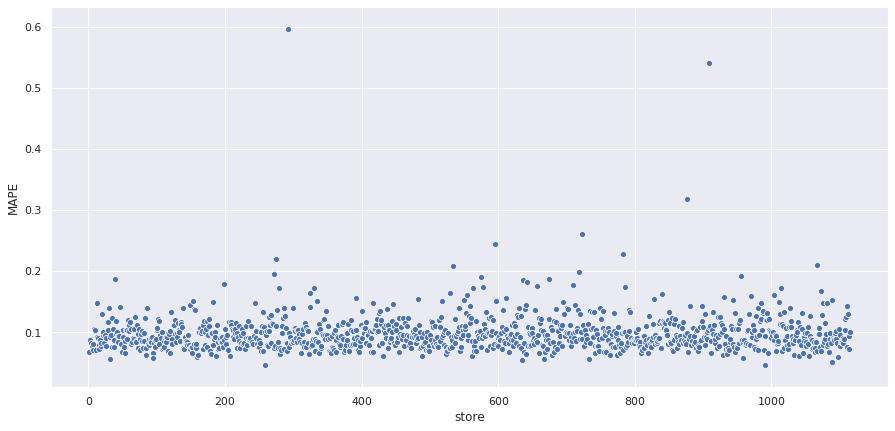

In [79]:
plt.figure(figsize = (15,7))
sns.scatterplot(x = 'store',y = 'MAPE', data = df92)

Oberserving the results, we can see that there are stores that have higher MAPE values. So, these are stores that presents a challenge to be solve. 

## 9.2. Total Performance

In [80]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {"index":"Scenario",0:"Values"})

df93['Values'] = df93['Values'].map("R${:,.2f}".format)
df93

,Scenario,Values
0,predictions,"R$276,866,143.07"
1,worst_scenario,"R$276,117,944.24"
2,best_scenario,"R$277,614,341.90"


## 9.3. Machine Learning Performance

In [81]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-81-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-81-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


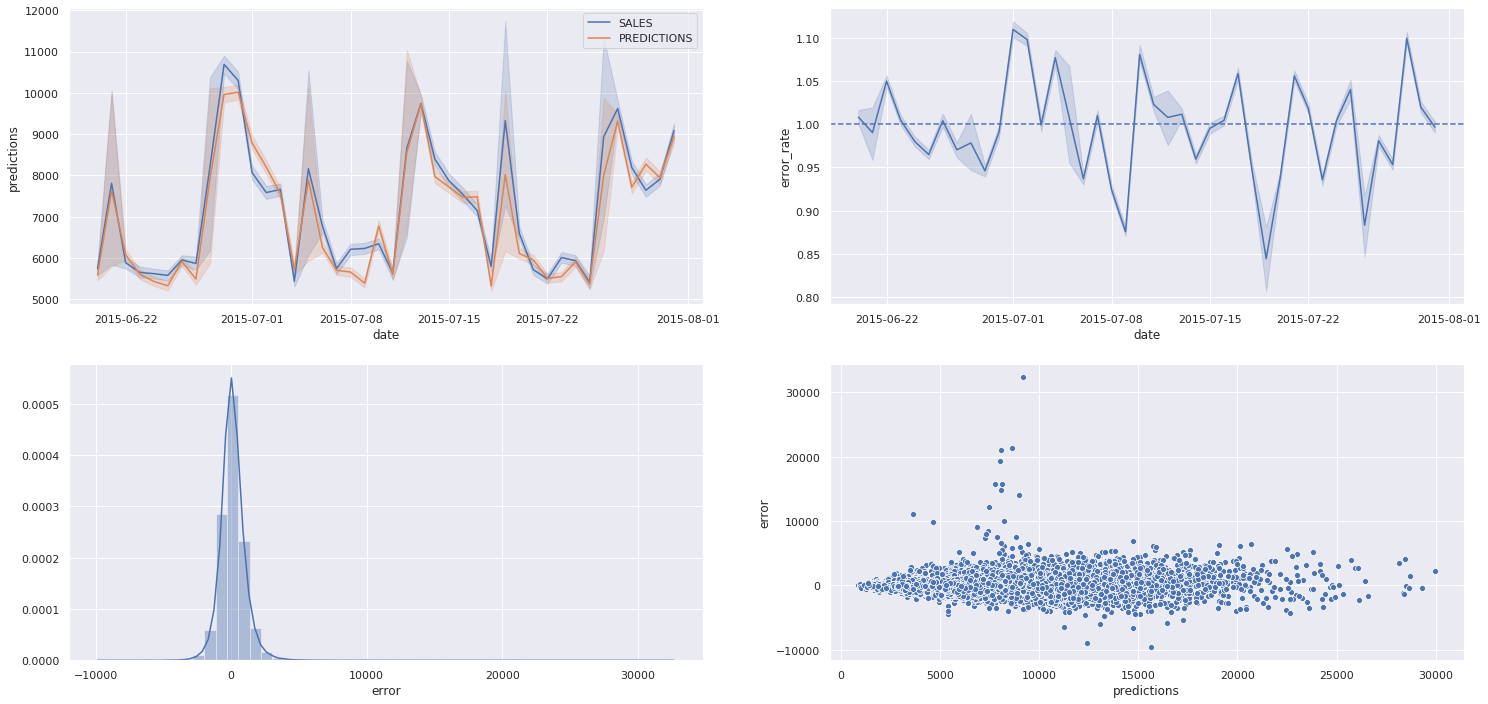

In [82]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

- By observing the first and second line plots, we can see that the predictions or our model is pretty close to the real value for sales. On the other hand, the error rate has some variance.

- Observing the histogram, the error distribution almost follow a normal distribution.

- Observing the scatterplot, there are some stores with higher error. However, the other points seems like a horizontal tube, which means that there are a few variation rate in the error.

# 10.0. DEPOLY MODEL TO PRODUCTION

In [54]:
#Save Trained Model
pickle.dump(model_xgb_tuned, open("/home/jorge/repos/portifolio/Rossmann_Challenge/model/model_rossmann.pkl", 'wb'))

## 10.1. Rossmann Class

In [55]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/jorge/repos/portifolio/Rossmann_Challenge/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [108]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/jorge/repos/portifolio/Rossmann_Challenge/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [70]:
# loading test dataset
df10 = pd.read_csv( '/home/jorge/repos/portifolio/Rossmann_Challenge/data/test.csv' )

In [71]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [30, 24, 25] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [72]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [73]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-deploy.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [74]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [75]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 24 will sell R$368,941.47 in the next 6 weeks
Store Number 25 will sell R$401,799.78 in the next 6 weeks
Store Number 30 will sell R$192,683.12 in the next 6 weeks
